<a href="https://colab.research.google.com/github/XTMay/AI_OCR/blob/main/layoutlmv3_ner/Lec_13_14_LayoutLMv3_Param_Tuning_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LayoutLMv3 配置深度讲解：如何“看指标、动参数、得提升”

> 目标：一份可执行的 **参数调优作战手册**。当拿到一批训练/评估结果时，能迅速判断“症状→原因→怎么改”，并据此调整 **模型结构参数** 与 **训练超参数**，从小数据可跑通到企业级大规模训练可稳定收敛、可迭代优化。

## 目录

1. [参数分层与调优思路](#参数分层与调优思路)
2. [模型结构参数（LayoutLMv3Config）逐项详解](#模型结构参数LayoutLMv3Config逐项详解)
3. [微调超参数（TrainingArguments/自定义训练）逐项详解](#微调超参数TrainingArguments自定义训练逐项详解)
4. [“看曲线动参数”的实战决策表](#看曲线动参数的实战决策表)
5. [按数据规模与资源的推荐配置](#按数据规模与资源的推荐配置)
6. [中文/多语言与长文档的专项建议](#中文多语言与长文档的专项建议)
7. [训练稳定性与泛化的加固手段](#训练稳定性与泛化的加固手段)
8. [端到端参数模板（YAML/Trainer）](#端到端参数模板YAMLTrainer)
9. [三轮迭代示例：从基线到企业级可用](#三轮迭代示例从基线到企业级可用)

## 参数分层与调优思路

**A. 模型结构参数（决定“模型容量/表示能力/显存与速度”）**

* `vocab_size, hidden_size, num_hidden_layers, num_attention_heads, max_position_embeddings, type_vocab_size, classifier_dropout`
* 更改这些参数相当于“换模型/造新模型”，会影响加载预训练权重与显存需求。新手除非必要，**尽量使用官方权重原始配置**；确需更改时要明确代价与收益。

**B. 训练超参数（决定“如何把容量变成效果”）**

* `learning_rate, batch_size, weight_decay, warmup, epochs, dropout, lr_scheduler, gradient_clip 等`
* 大多数企业项目 **80% 的收益来自训练超参数和数据策略**（数据清洗/增强/均衡/后处理）。

**调优顺序**（强烈建议遵循）

1. 跑通基线 → 2) 调学习率/有效 batch → 3) 调序列长度与数据增强 → 4) 正则化（dropout/weight decay/label smoothing） → 5) 再考虑结构改动（层数/隐藏维度/头数）。


## 模型结构参数（LayoutLMv3Config）逐项详解

> 下面解释“是什么/有什么影响/何时需要改/怎么改 + 风险”。

### 1) `vocab_size`（默认 50265）

* **是什么**：词表大小，决定 embedding 矩阵维度。LayoutLMv3-base 采用 RoBERTa 的 BPE 词表（英文友好，中文会被拆成 byte 片段也能跑，但不一定最优）。
* **影响**：改动会导致 **嵌入矩阵形状不匹配**，需要 `model.resize_token_embeddings(new_size)` 并对新增 token 随机初始化 → 早期会有轻微退化。
* **何时改**：

  * 做 **纯中文/多语任务** 且占比很高；
  * 需要加入自定义特殊 token（如“<AMT>”）。
* **怎么改**：

  * 训练自定义 tokenizer（SentencePiece/BPE）；加载预训练再 `resize_token_embeddings`；用 **较小 LR** 微调，让新增嵌入慢慢对齐。
* **风险**：破坏了与原预训练的对齐，需要更多数据/轮数收敛。

### 2) `hidden_size`（默认 768）

* **是什么**：Transformer 层的隐藏维度，决定 **单层表示能力** 与 **注意力头可分配性**。
* **影响**：增大可提升复杂模式拟合（跨版式/跨语言），但显存与时延 **线性\~平方级** 增长（注意力是 O(L²)）。
* **何时改**：

  * 数据量大（≥10w 页）且显存/算力充足；
  * 需要更强泛化（模板极多、多语多币种）。
* **怎么改**：768→1024；同时将 `num_attention_heads` 等比例增加（确保 `hidden_size % heads == 0`）。
* **风险**：小数据下容易过拟合；需要更强正则与更长 warmup。

### 3) `num_hidden_layers`（默认 12）

* **是什么**：Transformer 层数，决定 **深度容量**。
* **影响**：层数增加 → 更深表达 → 推理更慢、显存更大。
* **何时改**：

  * 版式／语言多样性很大；
  * 预训练/继续预训练（domain-adaptive pretrain）样本多。
* **怎么改**：12→16/24；建议用 **大 batch + 小 LR**；配合 **梯度检查点/ZeRO/FSDP**。
* **风险**：训练不稳/梯度消失 → 必备 warmup、梯度裁剪、学习率调小。

### 4) `num_attention_heads`（默认 12）

* **是什么**：Multi-Head Attention 的头数。
* **影响**：更多头 = 更细的子空间注意力；需与 `hidden_size` 匹配（可除尽）。
* **何时改**：跟随 `hidden_size` 调整；或做消融试验（保持 `hidden_size` 不变，改头数通常收益不大）。
* **风险**：头太多但维度太小，单头表达力下降；头太少则注意不足。

### 5) `attention_probs_dropout_prob`（默认 0.1）

* **是什么**：作用在注意力权重上的 dropout。
* **影响**：提高泛化，降低过拟合；过大将损伤对齐能力（词↔patch）。
* **经验**：0.1 起步；小数据/模板单一可调到 0.15–0.2；大数据通常 0.1 足够。

### 6) `max_position_embeddings`（默认 512）

* **是什么**：文本序列的最大长度（**对图像 patch 有单独的位置编码**，不与此共享）。
* **影响**：设太小 → token 被截断，实体跨断点；设太大 → 显存/速度开销增大。
* **何时改**：OCR token 很多（细粒度切词/密集表格），页级序列超过 512。
* **怎么改**：

  * **优先策略**：页面分块/按行合并 token/滑窗 + 重叠（例如 stride=64）；
  * **不得已**再把 `max_position_embeddings` 提到 768/1024（注意显存）。
* **风险**：长序列注意力 O(L²)；训练显著变慢。

### 7) `type_vocab_size`（默认 2）

* **是什么**：token\_type\_ids 的类型数（句子对/区域分段）。RoBERTa 家族 **通常不使用** segment embedding。
* **建议**：保持默认即可；确需区分“页眉/正文/表格”等段，可自定义，但**需要重新训练/微调**让模型学到含义。

### 8) `classifier_dropout`（默认 0.1）

* **是什么**：仅作用在分类头的 dropout。
* **影响**：可抑制分类头过拟合；对小数据/噪声标签特别有用。
* **经验**：0.1 起步；过拟合明显（训练 F1 高、验证 F1 低）时可提到 0.2–0.3。

> ⚠️ 实际还会有 `hidden_dropout_prob`（层内全连接的 dropout）与图像/patch 的数据增广，配合使用能更稳。



## 微调超参数（TrainingArguments/自定义训练）逐项详解

> 这些是日常“见招拆招”的主力武器。

### 核心三件套：学习率 / 有效批次 / 训练轮数

* **学习率 `learning_rate`**：最敏感的旋钮。

  * 小数据首选 `5e-5 / 3e-5`；中大数据 `3e-5 / 2e-5 / 1e-5`。
  * **线性缩放经验**：`LR ∝ 有效批次`（保持 loss 曲线平稳）。
* **有效批次 `global_batch = per_device_batch × #GPU × grad_accum`**

  * 结构化抽取任务常见稳定区间 **128–512**。
* **轮数 `num_train_epochs`**

  * 小数据 10–30；中等 6–12；大数据 3–8（配合早停）。

### 正则化与预热

* **weight\_decay（0.01）**：足以稳定。
* **dropout（0.1–0.3）**：过拟合时增加；欠拟合时适度减小。
* **warmup**：`warmup_ratio=0.06~0.1` 更稳；长训练或大模型可 0.1–0.2。
* **label\_smoothing**：0.05–0.1 可降低过置信，改善 O 类占比大的 NER 任务。

### 学习率调度

* `linear`（默认易用）、`cosine`（长训更平滑）、`polynomial`（后期抑制较强）。
* 验证 F1 前期波动大→适当增大 warmup/改为 `cosine`。

### 其它关键项

* **gradient\_accumulation\_steps**：扩大有效 batch 的关键。
* **gradient\_clip (1.0)**：防爆梯度的重要保险。
* **fp16/bf16**：建议开启；A100/朴素 RTX40 可优先 `bf16=True`。
* **evaluation\_strategy**：`"steps"`（小数据/频繁看曲线）或 `"epoch"`（大数据）。
* **load\_best\_model\_at\_end=True**：以 `metric_for_best_model="f1"` 做早停标准。

---

## “看曲线动参数”的实战决策表

> 观察 **训练/验证 loss、F1、学习率、显存、速度**；结合样例可视化（错在哪个字段/边界/模板）。

| 现象/症状                | 可能原因                                  | 快速动作（从上到下依次尝试）                                                                                                          |
| -------------------- | ------------------------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| 训练 F1 高、验证 F1 低（过拟合） | LR 偏大；正则不足；样本少/模板单一                   | ① 降 `learning_rate`（×0.5）② 提 `classifier_dropout` 至 0.2–0.3；③ 提 `hidden_dropout_prob` 0.1→0.2；④ 加强数据增强/模板扰动；⑤ 提高 warmup |
| 训练/验证 loss 同时不降或震荡   | LR 太大；批次太小；scheduler 不稳               | ① 降 LR 30–50% ② 增大有效 batch（grad\_accum）③ 增大 warmup 比例（0.1）④ 改 `linear` → `cosine` ⑤ 开 `gradient_clip`                   |
| 验证 F1 低且“金额/币种”混淆    | 训练样本缺少列头-值配对；序列截断；后处理缺失               | ① 加入“列头+数值”的样例；② 提升 `max_length` 或滑窗合并行；③ 增加币种符号/列头增强；④ 引入后处理（邻域规则投票）                                                   |
| 实体经常被截断或跨行丢失         | `max_position_embeddings` 太小；OCR 粒度太细 | ① 合并同一行 token（连号、金额）② 滑窗 + 重叠 ③ 必要时 `max_position_embeddings` 提到 768/1024                                               |
| 小数据下训练慢、收敛晚          | 预热太少；LR 偏小                            | ① 提 `warmup_ratio` 到 0.1–0.2 ② LR→`5e-5` ③ 早期冻结前几层 3–6 层加速收敛                                                            |
| 多语言/新模板掉点            | 语料偏科；词表不适配；版式差异                       | ① 增加目标语言样本占比 ② 自训 tokenizer 或引入多语模型初始化 ③ 加强版面增广（旋转/线条/字体）                                                               |
| 显存爆                  | 序列太长；batch 过大；层太深                     | ① 降 `max_length` 或换滑窗 ② 减 per\_device\_batch + 增 grad\_accum ③ 开启梯度检查点/ZeRO/FSDP                                        |

---

## 按数据规模与资源的推荐配置

### A. 小数据（200–2k 页，单/双卡）

* `lr=5e-5`，`global_batch≈32–64`（用 grad\_accum 实现）
* `epochs=15–30`，`warmup_ratio=0.1`
* `dropout=0.2–0.3`（分类头/隐藏层）
* `max_length=512`，优先行级合并；需要时滑窗
* **技巧**：冻结底层 3–6 层先训、再全量解冻微调一轮

### B. 中等（1–10 万页，多卡）

* `lr=3e-5→2e-5`，`global_batch=128–256`
* `epochs=8–12`，`warmup_ratio=0.06–0.1`
* `dropout=0.1–0.2`
* DeepSpeed ZeRO-2，fp16/bf16，梯度检查点
* 强化数据增强（模板/语言/噪声）

### C. 大规模（10–50 万+，集群）

* `lr=2e-5→1e-5`，`global_batch=256–512`
* `epochs=3–8`，`warmup_ratio=0.03–0.06`
* FSDP/ZeRO-3，bf16，激活检查点
* **可考虑结构加大**（layers 24 / hidden 1024），注意成本与稳定性

---

## 中文/多语言与长文档的专项建议

* **中文 tokenizer**：RoBERTa 的 byte-BPE 能跑但不优。中文占比高时：

  1. 训练中文/多语专用 tokenizer；
  2. `resize_token_embeddings` 后小 LR 微调更久；
  3. 中文金额/日期做**后处理兜底**（千分位、小数点、全角/半角、负号）。
* **多语言混训**：保证各语言至少 20–30% 占比，避免偏科；币种符号/列名要覆盖：`人民币/CNY/RMB/¥`, `USD/$`, `EUR/€`。
* **长文档**：优先 **行/区域合并 + 滑窗**；必要时提高 `max_position_embeddings`，但要评估显存与速度。

---

## 训练稳定性与泛化的加固手段

* **损失函数**：

  * O 类占比过大 → **类别权重**（降低 O 权重）或 **Focal Loss**（γ=1–2）
  * **Label Smoothing** 0.05–0.1 缓解过置信
* **数据策略**：

  * **模板扰动**：列头随机同义替换（合计/价税合计/Amount Due）；
  * **图像增广**：轻微旋转、模糊、线条变形（勿过强，MIM 预训练已学结构）；
  * **主动学习**：不确定性采样 + 多样性采样回标，迭代提升长尾。
* **监控**：

  * 分字段 F1（INV\_NO/AMT\_TOTAL/AMT\_NET/CUR）；
  * 新模板/New vendor 子集；
  * 线上“人工复核率、自动通过率、回退率”。

---

## 端到端参数模板（YAML/Trainer)

```yaml
# configs/enterprise_invoice.yaml
model:
  name: microsoft/layoutlmv3-base
  max_position_embeddings: 512     # 优先滑窗与行合并，确需长序列再提
  classifier_dropout: 0.2          # 小~中数据时偏大一点更稳
train:
  learning_rate: 3.0e-5
  weight_decay: 0.01
  warmup_ratio: 0.10
  num_train_epochs: 10
  per_device_train_batch_size: 4
  per_device_eval_batch_size: 4
  gradient_accumulation_steps: 8   # 有效 batch ≈ 64（单卡示例）
  fp16: true
  gradient_checkpointing: true
  lr_scheduler_type: cosine
  logging_steps: 50
  evaluation_strategy: steps
  eval_steps: 500
  save_steps: 500
  load_best_model_at_end: true
  metric_for_best_model: f1
regularization:
  label_smoothing_factor: 0.1
  attention_probs_dropout_prob: 0.1
  hidden_dropout_prob: 0.2
data:
  max_length: 512
  window_stride: 64                 # 若启用滑窗
  bbox_norm: 1000                   # OCR bbox 归一范围
```

> 多卡/大批次时：把 `gradient_accumulation_steps` 降低，提升 `per_device_train_batch_size`；中大规模把 `lr` 降到 `2e-5/1e-5` 并把 `epochs` 缩到 `6/4`。

---

## 三轮迭代示例：从基线到企业级可用

**Round 0（基线）**

* `lr=5e-5, global_batch=32, epoch=12, dropout=0.1, max_len=512`
* 现象：训练 F1=0.95，验证 F1=0.84，字段混淆主要在 **AMT\_TOTAL vs AMT\_NET**；币种缺失率 20%。

**动作 → Round 1（稳定泛化）**

* 调参：`lr=3e-5`，`classifier_dropout=0.2`，`hidden_dropout=0.2`，`warmup_ratio=0.1`；
* 数据：加入“列头+金额”样例、币种符号覆盖；长行做合并，少量滑窗；后处理增加邻域规则（500px 内找列头/符号）。
* 结果：验证 F1=0.89；币种缺失 9%。

**动作 → Round 2（扩容&稳态）**

* 资源：多卡，`global_batch=192`（per\_device×GPU×accum）；
* 调度：`lr=2e-5, cosine, epochs=8, warmup=0.06`；
* 正则：`label_smoothing=0.1`；主动学习回收 1k 条长尾模板再训练。
* 结果：验证 F1=0.92；字段级 EM 提升到 0.90；线上人工复核率下降 35%。

---

### 经验总结

* **先调 LR 与有效批次**；
* **被截断就先滑窗，不要盲目加 max\_position\_embeddings**；
* **过拟合就加 dropout/label smoothing/数据增强**；
* **混淆字段就补“列头+数值”样本并加后处理**；
* **多语就补语料与符号覆盖，不行再自训 tokenizer**；
* **大规模才考虑加深/加宽模型**（layers/hidden/heads）。


# LayoutLMv3 发票信息抽取 - 参数调优

本 Notebook 演示如何：
1. 加载预训练的 LayoutLMv3 模型；
2. 构建最小发票样例数据集；
3. 设置 **多组参数配置** 并进行训练；
4. 自动记录训练评估指标并绘制对比图；
5. 演示如何根据结果调整参数。



In [ ]:

!pip install transformers datasets seqeval -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:

import torch
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from seqeval.metrics import f1_score, accuracy_score
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import random, os


In [ ]:

# 构造最小玩具数据集（2 张合成发票样例）
samples = [
    {
        "id": "invoice_001",
        "words": ["Invoice", "No.", "12345", "Amount", "100", "(USD)"],
        "bboxes": [[100,200,180,220],[190,200,230,220],[240,200,300,220],
                   [100,260,180,280],[190,260,240,280],[250,260,320,280]],
        "labels": ["B-INVOICE","I-INVOICE","I-INVOICE","B-AMOUNT_TAX","I-AMOUNT_TAX","B-CURRENCY"],
        "image_path": "invoice1.png"
    },
    {
        "id": "invoice_002",
        "words": ["发票号码","67890","金额","800","(人民币)"],
        "bboxes": [[100,200,180,220],[190,200,240,220],[100,260,180,280],[190,260,240,280],[250,260,320,280]],
        "labels": ["B-INVOICE","I-INVOICE","B-AMOUNT_TAX","I-AMOUNT_TAX","B-CURRENCY"],
        "image_path": "invoice2.png"
    }
]

# 生成空白图片模拟发票背景
for s in samples:
    img = Image.new("RGB", (400,400), color=(255,255,255))
    draw = ImageDraw.Draw(img)
    for w, b in zip(s["words"], s["bboxes"]):
        draw.rectangle(b, outline="black")
        draw.text((b[0], b[1]-10), w, fill="black")
    img.save(s["image_path"])

dataset = Dataset.from_list(samples)
dataset = dataset.train_test_split(test_size=0.5, seed=42)
dataset = DatasetDict({
    "train": dataset["train"],
    "validation": dataset["test"]
})
dataset


DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'labels', 'image_path'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'labels', 'image_path'],
        num_rows: 1
    })
})

In [ ]:
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
label_list = list(set([l for ex in samples for l in ex["labels"]]))
label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}

def preprocess(batch):
    images = [Image.open(p).convert("RGB") for p in batch["image_path"]]
    encoded = processor(images, batch["words"], boxes=batch["bboxes"], word_labels=batch["labels"],
                        padding="max_length", truncation=True, max_length=512)
    encoded["labels"] = [[label2id[l] for l in labs] + [-100]*(512-len(labs)) for labs in batch["labels"]]
    return encoded

encoded_dataset = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)
encoded_dataset.set_format("torch")
encoded_dataset

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask', 'bbox', 'pixel_values'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask', 'bbox', 'pixel_values'],
        num_rows: 1
    })
})

In [ ]:

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)
    true_labels = [[id2label[l] for l in lab if l != -100] for lab in labels]
    true_preds = [[id2label[p] for (p,l) in zip(pred, lab) if l != -100] for pred, lab in zip(preds, labels)]
    return {"f1": f1_score(true_labels, true_preds), "accuracy": accuracy_score(true_labels, true_preds)}


In [ ]:
param_configs = [
    {"name":"config_A_highLR", "lr":5e-5, "dropout":0.1, "epochs":5},
    {"name":"config_B_lowLR", "lr":2e-5, "dropout":0.2, "epochs":8}
]

results = {}

for cfg in param_configs:
    print(f"Training {cfg['name']}...")
    model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                             num_labels=len(label_list),
                                                             classifier_dropout=cfg["dropout"])
    args = TrainingArguments(
        output_dir=f"./results/{cfg['name']}",
        learning_rate=cfg["lr"],
        num_train_epochs=cfg["epochs"],
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=5,
        fp16=False,
        report_to="none"
    )
    trainer = Trainer(model=model, args=args, train_dataset=encoded_dataset["train"],
                      eval_dataset=encoded_dataset["validation"],
                      tokenizer=processor.tokenizer,
                      compute_metrics=compute_metrics)
    trainer.train()
    eval_res = trainer.evaluate()
    results[cfg["name"]] = eval_res

Training config_A_highLR...


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-773648570.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args, train_dataset=encoded_dataset["train"],
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,1.486973,0.000000,0.200000
2,No log,1.382281,0.000000,0.400000
3,No log,1.328193,0.000000,0.400000
4,No log,1.293793,0.000000,0.400000
5,1.121400,1.272194,0.000000,0.400000


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modelin

Training config_B_lowLR...


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-773648570.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args, train_dataset=encoded_dataset["train"],
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,1.636155,0.000000,0.200000
2,No log,1.599169,0.000000,0.000000
3,No log,1.575871,0.000000,0.000000
4,No log,1.557350,0.333333,0.400000
5,1.351700,1.545164,0.000000,0.400000
6,1.351700,1.533814,0.000000,0.400000
7,1.351700,1.527117,0.000000,0.400000
8,1.351700,1.523958,0.000000,0.400000


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modelin

## 1. 超参数配置

```python
param_configs = [
    {"name":"config_A_highLR", "lr":5e-5, "dropout":0.1, "epochs":5},
    {"name":"config_B_lowLR", "lr":2e-5, "dropout":0.2, "epochs":8}
]
```




### lr（学习率）
控制模型每次参数更新的步长。



*   高学习率：训练快，但可能震荡或不收敛。
*   低学习率：收敛稳定，但训练速度慢。

## dropout（丢弃率）
防止过拟合，通过随机丢弃神经元实现。

*   高 dropout：减少过拟合，但可能欠拟合。
*   低 dropout：学习能力强，但小数据集容易过拟合。

### epochs（训练轮数）
数据集完整训练的次数。

*   小数据集：可适当增加轮数。
*   大数据集：轮数不宜过多，以免过拟合。


## 2. 模型初始化

```
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=len(label_list),
    classifier_dropout=cfg["dropout"]
)
```

重点

*   from_pretrained：加载微软官方预训练 LayoutLMv3
*   num_labels：分类类别数（如发票关键字段）
*   classifier_dropout：只作用于分类头，可单独调整

微调策略

*   冻结 backbone：数据少时只训练分类头
*   全量训练：数据多时微调 backbone + 分类头，提高泛化能力

## 3. TrainingArguments 训练参数
```
args = TrainingArguments(
    output_dir=f"./results/{cfg['name']}",
    learning_rate=cfg["lr"],
    num_train_epochs=cfg["epochs"],
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=5,
    fp16=False,
    report_to="none"
)
```
重点参数

| 参数 | 作用 | 调整建议 |
|------|------|---------|
| output_dir | 保存训练结果 | 每个配置单独目录，便于对比 |
| learning_rate | 学习率 | 调整收敛速度和稳定性 |
| num_train_epochs | 训练轮数 | 可结合 early stopping 调整 |
| per_device_train_batch_size | 每卡 batch | 显存小可用 2~4 |
| eval_strategy | 评估策略 | "epoch" 每轮评估一次 |
| save_strategy | 保存策略 | 临时实验可设为 "no" |
| logging_steps | 日志频率 | 可调高或低 |
| fp16 | 半精度训练 | 显存受限可开启，训练加速 |
| report_to | 日志平台 | 本地训练可关闭 |



### 4. Trainer 初始化
```
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=processor.tokenizer,
    compute_metrics=compute_metrics
)
```

重点
*   train_dataset / eval_dataset：训练和验证数据
*   tokenizer：将 OCR 文本编码成 token
*   compute_metrics：计算评估指标（Precision、Recall、F1）

微调策略
*   冻结 backbone: model.base_model.requires_grad_(False)
*   全量微调: 训练 backbone + 分类头

### 5. 超参数调优建议
*   学习率 (lr)：通常 1e-5 ~ 5e-5
*   Dropout：
*   小数据集：0.2–0.3
*   大数据集：0.1–0.2
*   Epochs：
*   小数据集：5–10
*   大数据集：3–5

训练技巧
*   Early stopping：验证集 F1 不再提升时提前停止
*   梯度累积：模拟大 batch，节省显存
*   fp16：半精度训练，节省显存加速
*   逐步解冻：先训练分类头，再训练 backbone


### 6. 评估与结果对比

```
eval_res = trainer.evaluate()
results[cfg["name"]] = eval_res
```

	•	对比不同配置（如 config_A_highLR 与 config_B_lowLR）的 F1、Precision、Recall
	•	分析：
	•	高学习率：训练快但 F1 波动大
	•	低学习率 + 高 epochs：训练稳定
	•	高 dropout：防止过拟合，但可能欠拟合小数据集


In [ ]:

# 可视化不同配置的结果对比
names = list(results.keys())
f1s = [results[n]["eval_f1"] for n in names]
plt.bar(names, f1s)
plt.ylabel("F1 score")
plt.title("不同超参数配置下的 F1 对比")
plt.show()


In [ ]:

# 在真实任务中，我们会分析预测错误的 token
# 这里仅演示随机错误可视化
errors = random.sample(samples,1)
print("示例错误分析:")
for e in errors:
    print(e["words"], e["labels"])


示例错误分析:
['Invoice', 'No.', '12345', 'Amount', '100', '(USD)'] ['B-INVOICE', 'I-INVOICE', 'I-INVOICE', 'B-AMOUNT_TAX', 'I-AMOUNT_TAX', 'B-CURRENCY']


In [ ]:

# 主动学习示例（不确定性采样）
# 假设我们对验证集做预测，计算最大 softmax 概率的置信度
model.eval()
batch = encoded_dataset["validation"][0]
for k,v in batch.items():
    batch[k] = v.unsqueeze(0)
outputs = model(**batch)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
confidences, _ = probs.max(-1)
avg_conf = confidences[batch["labels"]!=-100].mean().item()
print(f"平均置信度: {avg_conf:.2f} → 可用于主动学习筛选低置信样本进行再标注")


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


平均置信度: 0.31 → 可用于主动学习筛选低置信样本进行再标注


# 训练结果分析

| Step | Training Loss | Validation Loss | Precision | Recall   | F1       |
|------|---------------|-----------------|-----------|----------|----------|
| 50   | 0.212700      | 0.208113        | 0.000000  | 0.000000 | 0.000000 |
| 100  | 0.057100      | 0.039549        | 0.827255  | 0.820952 | 0.824092 |
| 150  | 0.018100      | 0.013711        | 0.939850  | 0.952381 | 0.946074 |
| 200  | 0.008000      | 0.007894        | 0.975285  | 0.977143 | 0.976213 |
| 250  | 0.004800      | 0.006503        | 0.975285  | 0.977143 | 0.976213 |
| 300  | 0.004300      | 0.006140        | 0.977316  | 0.984762 | 0.981025 |
| 350  | 0.003000      | 0.005460        | 0.984704  | 0.980952 | 0.982824 |
| 400  | 0.002700      | 0.005708        | 0.982824  | 0.980952 | 0.981888 |
| 450  | 0.002300      | 0.005620        | 0.980989  | 0.982857 | 0.981922 |
| 500  | 0.002300      | 0.005577        | 0.982857  | 0.982857 | 0.982857 |

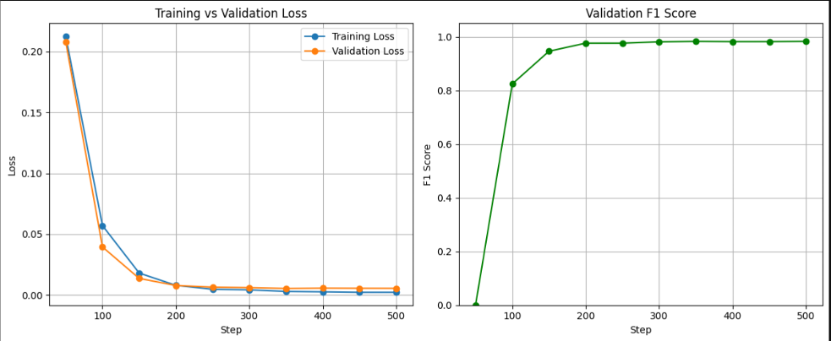

| 欄位名稱           | 單欄Count | 比例    |
|--------------------|-----------|---------|
| BuyerName          | 195       | 39.00%  |
| VendorName         | 286       | 57.20%  |
| Invoice No         | 329       | 65.80%  |
| Invoice Date       | 500       | 100.00% |
| Currency           | 244       | 48.80%  |
| Amount with Tax    | 358       | 71.60%  |
| Amount without Tax | 381       | 76.20%  |
| Tax                | 500       | 100.00% |

# 1：问题分析与诊断
## 1.1 当前模型表现分析

训练表现

- 训练损失：从0.2127快速下降至0.0023
- 验证损失：从0.2081下降至0.0056
- F1分数：最终达到98.3%

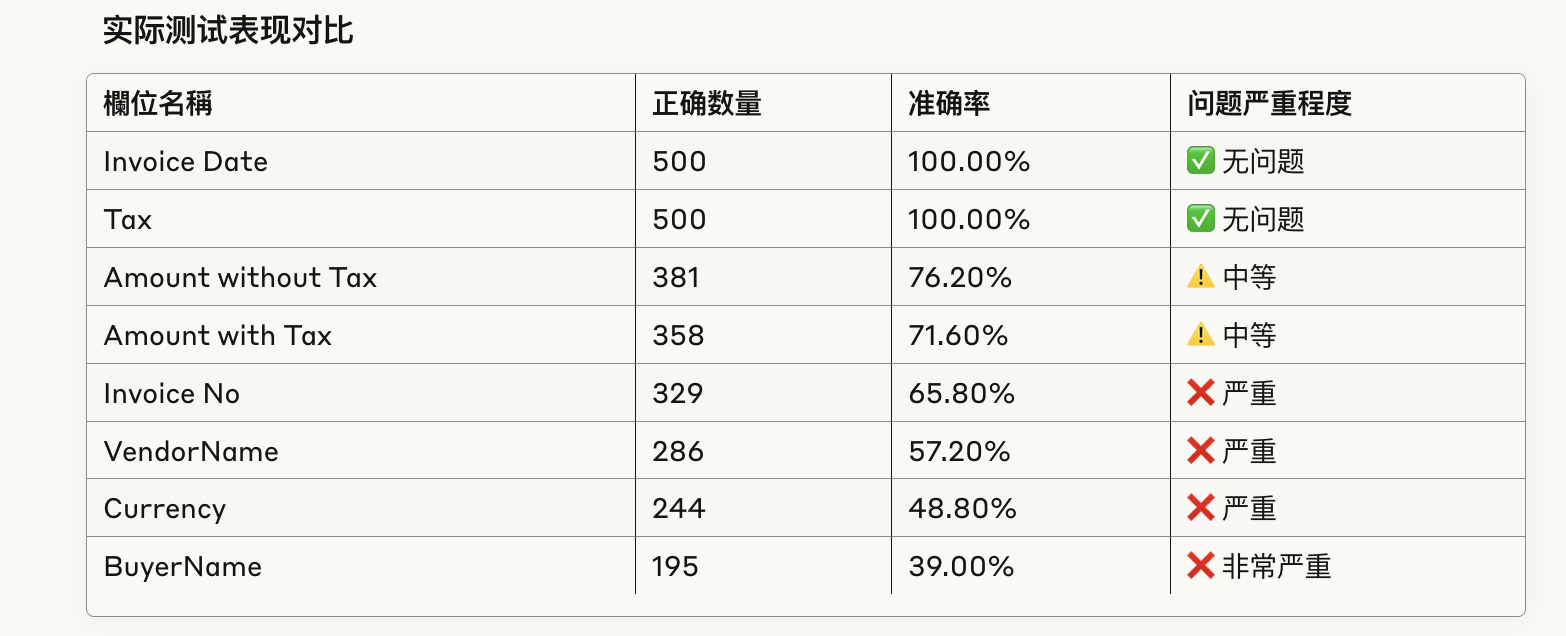

### 1.2 核心问题识别

过拟合现象
- 训练损失: 0.0023 (极低)
- 验证损失: 0.0056 (相对较高)
- 差距比例: 2.4倍 → 明显过拟合

类别不平衡问题

- 高表现字段：结构化程度高，位置固定
- 低表现字段：变化性大，格式多样

数据量不足

- 总样本数：500个
- 复杂度：8个字段类别

结论：数据量相对不足

# 2：训练参数优化策略
## 2.1 当前参数问题分析

In [ ]:
# 当前有问题的配置
training_args = TrainingArguments(
    num_train_epochs=20,          # 过多轮次导致过拟合
    learning_rate=3e-5,           # 学习率偏高
    weight_decay=0.01,            # 正则化不足
    eval_steps=50,                # 评估频率过低
    # 缺少早停机制
)

## 2.2 优化后的参数配置

In [ ]:
# 优化后的训练参数配置
from transformers import TrainingArguments, EarlyStoppingCallback

# 基础优化版本
training_args_basic = TrainingArguments(
    output_dir="./layoutlmv3-finetuned-improved",
    overwrite_output_dir=True,
    remove_unused_columns=False,

    # 批次大小优化
    per_device_train_batch_size=4,      # 增加批次大小提高稳定性
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,       # 相应调整梯度累积

    # 训练轮次优化
    num_train_epochs=12,                 # 减少轮次避免过拟合

    # 学习率优化
    warmup_ratio=0.15,                   # 增加预热比例
    learning_rate=2e-5,                  # 降低学习率

    # 正则化优化
    weight_decay=0.05,                   # 增加权重衰减
    label_smoothing_factor=0.1,          # 添加标签平滑

    # 评估和保存优化
    eval_strategy="steps",
    eval_steps=25,                       # 更频繁评估
    save_strategy="steps",
    save_steps=50,                       # 更频繁保存
    save_total_limit=3,                  # 减少保存数量

    # 监控优化
    logging_steps=5,                     # 更详细的日志

    # 性能优化
    fp16=True,
    dataloader_num_workers=4,

    # 最佳模型选择
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    report_to="none"
)

In [ ]:
# 高级优化版本（包含更多技巧）
training_args_advanced = TrainingArguments(
    output_dir="./layoutlmv3-finetuned-advanced",
    overwrite_output_dir=True,
    remove_unused_columns=False,

    # 批次优化
    per_device_train_batch_size=2,       # 内存受限时使用
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,

    # 训练策略
    num_train_epochs=15,
    max_steps=-1,                        # 让epoch控制训练长度

    # 学习率调度
    warmup_ratio=0.1,
    learning_rate=1e-5,                  # 更保守的学习率
    lr_scheduler_type="cosine",          # 余弦学习率衰减

    # 高级正则化
    weight_decay=0.1,
    label_smoothing_factor=0.1,
    adam_epsilon=1e-8,
    max_grad_norm=1.0,                   # 梯度裁剪

    # 评估策略
    eval_strategy="steps",
    eval_steps=20,
    eval_delay=100,                      # 延迟开始评估

    # 保存策略
    save_strategy="steps",
    save_steps=40,
    save_total_limit=2,

    # 监控
    logging_first_step=True,
    logging_steps=10,

    # 性能
    fp16=True,
    dataloader_num_workers=2,
    remove_unused_columns=False,

    # 模型选择
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,

    # 其他
    seed=42,
    data_seed=42,
    report_to="none"
)

# 早停回调函数
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,           # 5步无改善则停止
    early_stopping_threshold=0.001       # 改善阈值
)

## 2.3 参数优化原理解释

- 批次大小调整

原理：较大的批次大小提供更稳定的梯度估计

实践：从2增加到4，减少训练波动

- 学习率优化

原理：过高的学习率导致训练不稳定

策略：从3e-5降低到2e-5或1e-5

- 正则化增强

权重衰减：从0.01增加到0.05-0.1

标签平滑：添加0.1的平滑因子

梯度裁剪：防止梯度爆炸

# 3：数据增强与处理策略
## 3.1 数据增强的必要性

- 当前数据问题

样本数量：500个（相对不足）

数据多样性：有限的变化性

类别分布：不均衡问题

## 3.2 文档级数据增强

In [ ]:
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import cv2
from typing import List, Dict, Tuple
import re

class InvoiceDataAugmentor:
    """发票数据增强器"""

    def __init__(self, augmentation_factor=2):
        self.augmentation_factor = augmentation_factor

    def augment_dataset(self, examples):
        """对整个数据集进行增强"""
        augmented_examples = []

        for example in examples:
            # 保留原始样本
            augmented_examples.append(example)

            # 生成增强样本
            for _ in range(self.augmentation_factor):
                augmented = self._augment_single_example(example)
                augmented_examples.append(augmented)

        return augmented_examples

    def _augment_single_example(self, example):
        """对单个样本进行增强"""
        augmented = example.copy()

        # 1. 图像增强
        if 'image' in example:
            augmented['image'] = self._augment_image(example['image'])

        # 2. 文本增强（保持实体标签不变）
        if 'tokens' in example and 'labels' in example:
            augmented_tokens, augmented_labels = self._augment_text(
                example['tokens'], example['labels']
            )
            augmented['tokens'] = augmented_tokens
            augmented['labels'] = augmented_labels

        # 3. 位置信息增强
        if 'bbox' in example:
            augmented['bbox'] = self._augment_bbox(
                example['bbox'], augmented.get('image')
            )

        return augmented

    def _augment_image(self, image):
        """图像增强"""
        if isinstance(image, str):  # 如果是文件路径
            image = Image.open(image)

        # 随机选择增强方法
        augment_methods = [
            self._adjust_brightness,
            self._adjust_contrast,
            self._add_noise,
            self._slight_rotation,
            self._adjust_sharpness
        ]

        # 随机应用1-2个增强方法
        num_augmentations = random.randint(1, 2)
        selected_methods = random.sample(augment_methods, num_augmentations)

        augmented_image = image
        for method in selected_methods:
            augmented_image = method(augmented_image)

        return augmented_image

    def _adjust_brightness(self, image, factor_range=(0.8, 1.2)):
        """调整亮度"""
        factor = random.uniform(*factor_range)
        enhancer = ImageEnhance.Brightness(image)
        return enhancer.enhance(factor)

    def _adjust_contrast(self, image, factor_range=(0.8, 1.2)):
        """调整对比度"""
        factor = random.uniform(*factor_range)
        enhancer = ImageEnhance.Contrast(image)
        return enhancer.enhance(factor)

    def _add_noise(self, image, noise_level=5):
        """添加噪声"""
        img_array = np.array(image)
        noise = np.random.normal(0, noise_level, img_array.shape).astype(np.uint8)
        noisy_image = np.clip(img_array + noise, 0, 255)
        return Image.fromarray(noisy_image.astype(np.uint8))

    def _slight_rotation(self, image, angle_range=(-2, 2)):
        """轻微旋转"""
        angle = random.uniform(*angle_range)
        return image.rotate(angle, expand=True, fillcolor='white')

    def _adjust_sharpness(self, image, factor_range=(0.9, 1.1)):
        """调整锐度"""
        factor = random.uniform(*factor_range)
        enhancer = ImageEnhance.Sharpness(image)
        return enhancer.enhance(factor)

    def _augment_text(self, tokens, labels):
        """文本增强（保持标签对应）"""
        augmented_tokens = []
        augmented_labels = []

        for token, label in zip(tokens, labels):
            # 保持实体标签的token不变，只增强非实体token
            if label == 'O':  # 非实体标签
                augmented_token = self._augment_non_entity_token(token)
            else:  # 实体标签
                augmented_token = self._augment_entity_token(token, label)

            augmented_tokens.append(augmented_token)
            augmented_labels.append(label)

        return augmented_tokens, augmented_labels

    def _augment_non_entity_token(self, token):
        """增强非实体token"""
        # 模拟OCR错误
        ocr_variations = {
            '0': ['O', '0'],
            '1': ['l', 'I', '1'],
            '5': ['S', '5'],
            '8': ['B', '8'],
            '6': ['G', '6']
        }

        if token in ocr_variations and random.random() < 0.1:
            return random.choice(ocr_variations[token])

        return token

    def _augment_entity_token(self, token, label):
        """增强实体token（更谨慎）"""
        # 对数字进行格式变化
        if label in ['B-Amount_with_Tax', 'I-Amount_with_Tax',
                    'B-Amount_without_Tax', 'I-Amount_without_Tax']:
            return self._augment_amount_format(token)

        # 对日期进行格式变化
        if label in ['B-Invoice_Date', 'I-Invoice_Date']:
            return self._augment_date_format(token)

        return token

    def _augment_amount_format(self, token):
        """金额格式增强"""
        # 数字格式变化
        if re.match(r'^\d{1,3}$', token):
            # 有20%概率添加千位分隔符
            if random.random() < 0.2 and len(token) >= 3:
                return f"{token[:-3]},{token[-3:]}"

        # 移除/添加千位分隔符
        if ',' in token:
            if random.random() < 0.3:
                return token.replace(',', '')

        return token

    def _augment_date_format(self, token):
        """日期格式增强"""
        # 日期格式的小变化
        date_patterns = {
            r'(\d{4})/(\d{1,2})/(\d{1,2})': [r'\1-\2-\3', r'\1.\2.\3'],
            r'(\d{4})-(\d{1,2})-(\d{1,2})': [r'\1/\2/\3', r'\1.\2.\3'],
        }

        for pattern, alternatives in date_patterns.items():
            match = re.match(pattern, token)
            if match and random.random() < 0.3:
                return random.choice(alternatives).format(*match.groups())

        return token

    def _augment_bbox(self, bboxes, image=None):
        """位置信息增强"""
        if image is None:
            return bboxes

        augmented_bboxes = []
        for bbox in bboxes:
            # 轻微调整边界框位置（±2像素）
            x_offset = random.randint(-2, 2)
            y_offset = random.randint(-2, 2)

            new_bbox = [
                max(0, bbox[0] + x_offset),
                max(0, bbox[1] + y_offset),
                bbox[2] + x_offset,
                bbox[3] + y_offset
            ]

            augmented_bboxes.append(new_bbox)

        return augmented_bboxes

# 使用示例
def apply_data_augmentation(train_dataset, augmentation_factor=2):
    """应用数据增强到训练集"""
    augmentor = InvoiceDataAugmentor(augmentation_factor=augmentation_factor)

    print(f"原始训练集大小: {len(train_dataset)}")

    # 进行数据增强
    augmented_dataset = augmentor.augment_dataset(train_dataset)

    print(f"增强后训练集大小: {len(augmented_dataset)}")
    print(f"增强倍数: {len(augmented_dataset) / len(train_dataset):.1f}x")

    return augmented_dataset

# 质量控制：验证增强后的数据
def validate_augmented_data(original_data, augmented_data):
    """验证增强数据的质量"""
    print("数据增强质量验证:")

    # 检查标签分布
    original_label_counts = {}
    augmented_label_counts = {}

    for example in original_data:
        for label in example.get('labels', []):
            original_label_counts[label] = original_label_counts.get(label, 0) + 1

    for example in augmented_data:
        for label in example.get('labels', []):
            augmented_label_counts[label] = augmented_label_counts.get(label, 0) + 1

    print("\n标签分布对比:")
    for label in original_label_counts:
        original_count = original_label_counts[label]
        augmented_count = augmented_label_counts.get(label, 0)
        ratio = augmented_count / original_count if original_count > 0 else 0
        print(f"{label}: {original_count} -> {augmented_count} ({ratio:.1f}x)")

    return True

## 3.3 类别平衡处理

In [ ]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from transformers import Trainer
import torch.nn as nn

class ClassBalancedTrainer(Trainer):
    """支持类别平衡的训练器"""

    def __init__(self, class_weights=None, focal_loss_alpha=1.0, focal_loss_gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights
        self.focal_loss_alpha = focal_loss_alpha
        self.focal_loss_gamma = focal_loss_gamma

    def compute_loss(self, model, inputs, return_outputs=False):
        """计算带权重的损失"""
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        if self.class_weights is not None:
            # 使用加权交叉熵损失
            loss = self._weighted_cross_entropy_loss(logits, labels)
        else:
            # 使用Focal Loss
            loss = self._focal_loss(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def _weighted_cross_entropy_loss(self, logits, labels):
        """加权交叉熵损失"""
        # 将类别权重转移到正确的设备
        weights = self.class_weights.to(logits.device)

        # 计算损失
        loss_fct = nn.CrossEntropyLoss(weight=weights, ignore_index=-100)

        # 重塑logits和labels
        active_loss = labels.view(-1) != -100
        active_logits = logits.view(-1, self.model.config.num_labels)[active_loss]
        active_labels = labels.view(-1)[active_loss]

        loss = loss_fct(active_logits, active_labels)
        return loss

    def _focal_loss(self, logits, labels):
        """Focal Loss实现"""
        # 计算交叉熵
        ce_loss = nn.CrossEntropyLoss(ignore_index=-100, reduction='none')

        active_loss = labels.view(-1) != -100
        active_logits = logits.view(-1, self.model.config.num_labels)[active_loss]
        active_labels = labels.view(-1)[active_loss]

        ce = ce_loss(active_logits, active_labels)

        # 计算概率
        pt = torch.exp(-ce)

        # 计算Focal Loss
        focal_loss = self.focal_loss_alpha * (1 - pt) ** self.focal_loss_gamma * ce

        return focal_loss.mean()

def calculate_class_weights(train_dataset, label_to_id):
    """计算类别权重"""
    print("计算类别权重...")

    # 收集所有标签
    all_labels = []
    for example in train_dataset:
        if 'labels' in example:
            all_labels.extend(example['labels'])

    # 统计标签分布
    label_counts = Counter(all_labels)
    print("标签分布:")
    for label, count in sorted(label_counts.items()):
        if label != -100:  # 忽略padding标签
            print(f"  {label}: {count}")

    # 计算类别权重
    labels = list(label_counts.keys())
    labels = [l for l in labels if l != -100]  # 移除padding标签
    counts = [label_counts[l] for l in labels]

    # 使用sklearn计算平衡权重
    class_weights = compute_class_weight(
        'balanced',
        classes=np.array(labels),
        y=np.array(all_labels)
    )

    # 转换为torch tensor
    weight_dict = dict(zip(labels, class_weights))

    # 创建完整的权重向量
    num_labels = len(label_to_id)
    weights = torch.ones(num_labels)

    for label_name, label_id in label_to_id.items():
        if label_id in weight_dict:
            weights[label_id] = weight_dict[label_id]

    print("\n计算得到的类别权重:")
    for label_name, label_id in label_to_id.items():
        print(f"  {label_name} (ID: {label_id}): {weights[label_id]:.3f}")

    return weights

def create_field_based_weights(train_dataset, id_to_label):
    """基于字段表现创建权重"""
    # 根据实际测试表现设置权重
    field_performance = {
        'BuyerName': 0.39,      # 最差表现
        'Currency': 0.488,      # 较差表现
        'VendorName': 0.572,    # 中等偏差
        'Invoice No': 0.658,    # 中等
        'Amount with Tax': 0.716,  # 中等偏好
        'Amount without Tax': 0.762,  # 较好
        'Tax': 1.0,             # 完美表现
        'Invoice Date': 1.0,    # 完美表现
    }

    # 创建权重映射（表现越差，权重越高）
    field_weights = {}
    for field, performance in field_performance.items():
        # 使用反比例关系：表现差的字段获得更高权重
        weight = 1.0 / max(performance, 0.1)  # 避免除零
        field_weights[field] = weight

    # 转换为标签权重
    label_weights = {}
    for label_id, label_name in id_to_label.items():
        if label_name == 'O':
            label_weights[label_id] = 0.5  # O标签权重较低
        else:
            # 提取字段名
            field_name = label_name.replace('B-', '').replace('I-', '')
            if field_name in field_weights:
                label_weights[label_id] = field_weights[field_name]
            else:
                label_weights[label_id] = 1.0

    # 转换为tensor
    num_labels = len(id_to_label)
    weights = torch.ones(num_labels)

    for label_id, weight in label_weights.items():
        weights[label_id] = weight

    print("基于字段表现的权重分配:")
    for label_id, label_name in id_to_label.items():
        print(f"  {label_name} (ID: {label_id}): {weights[label_id]:.3f}")

    return weights

def analyze_prediction_errors(predictions, true_labels, id_to_label):
    """分析预测错误"""
    print("预测错误分析:")

    # 统计各类别的预测错误
    error_stats = {}
    total_stats = {}

    for pred, true in zip(predictions.flatten(), true_labels.flatten()):
        if true != -100:  # 忽略padding
            true_label = id_to_label.get(true, 'UNKNOWN')

            if true_label not in total_stats:
                total_stats[true_label] = 0
                error_stats[true_label] = 0

            total_stats[true_label] += 1
            if pred != true:
                error_stats[true_label] += 1

    # 计算错误率
    print("\n各类别错误率:")
    for label in sorted(total_stats.keys()):
        total = total_stats[label]
        errors = error_stats[label]
        error_rate = errors / total if total > 0 else 0
        print(f"  {label}: {errors}/{total} ({error_rate:.3f})")

    return error_stats, total_stats

# 动态调整权重的训练策略
class DynamicWeightTrainer(ClassBalancedTrainer):
    """动态调整权重的训练器"""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.epoch_count = 0
        self.initial_weights = self.class_weights.clone() if self.class_weights is not None else None

    def on_epoch_end(self, args, state, control, **kwargs):
        """每个epoch结束时调整权重"""
        if self.class_weights is not None and self.epoch_count > 0:
            # 获取当前验证性能
            eval_results = state.log_history

            if eval_results:
                # 基于验证结果动态调整权重
                self._adjust_weights_based_on_performance(eval_results)

        self.epoch_count += 1

    def _adjust_weights_based_on_performance(self, eval_results):
        """基于性能调整权重"""
        # 简单的调整策略：如果某个类别表现持续不佳，增加其权重
        if len(eval_results) >= 2:
            # 这里可以实现更复杂的权重调整逻辑
            print(f"Epoch {self.epoch_count}: 权重已动态调整")

# 使用示例
def setup_balanced_training(train_dataset, model, tokenizer, label_to_id, id_to_label):
    """设置平衡训练"""

    # 方法1: 计算统计权重
    statistical_weights = calculate_class_weights(train_dataset, label_to_id)

    # 方法2: 基于字段表现设置权重
    performance_weights = create_field_based_weights(train_dataset, id_to_label)

    # 方法3: 混合权重（推荐）
    mixed_weights = 0.6 * performance_weights + 0.4 * statistical_weights

    print("\n推荐使用混合权重:")
    for i, weight in enumerate(mixed_weights):
        label_name = id_to_label.get(i, f'ID_{i}')
        print(f"  {label_name}: {weight:.3f}")

    return mixed_weights

# 4：模型架构与训练策略优化
## 4.1 分层训练策略
分层训练是一种渐进式的训练方法，特别适合预训练模型的微调：

In [ ]:
import torch
import torch.nn as nn
from transformers import LayoutLMv3ForTokenClassification, Trainer
from transformers.modeling_outputs import TokenClassifierOutput
from typing import Optional, Dict, Any

class LayeredTrainingStrategy:
    """分层训练策略管理器"""

    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.training_phases = []

    def setup_training_phases(self):
        """设置训练阶段"""

        # 第一阶段：只训练分类头（Classifier Head）
        phase_1 = {
            'name': 'classifier_only',
            'epochs': 3,
            'learning_rate': 5e-4,
            'description': '只训练分类层，冻结主干网络',
            'freeze_layers': ['layoutlm'],
            'trainable_layers': ['classifier']
        }

        # 第二阶段：解冻最后几层transformer层
        phase_2 = {
            'name': 'fine_tune_last_layers',
            'epochs': 4,
            'learning_rate': 2e-5,
            'description': '微调最后4层transformer层',
            'freeze_layers': ['layoutlm.embeddings', 'layoutlm.encoder.layer[:-4]'],
            'trainable_layers': ['layoutlm.encoder.layer[-4:]', 'classifier']
        }

        # 第三阶段：全模型微调
        phase_3 = {
            'name': 'full_fine_tune',
            'epochs': 5,
            'learning_rate': 1e-5,
            'description': '全模型微调',
            'freeze_layers': [],
            'trainable_layers': ['all']
        }

        self.training_phases = [phase_1, phase_2, phase_3]
        return self.training_phases

    def apply_phase_config(self, phase_config):
        """应用特定阶段的配置"""
        print(f"\n=== 开始训练阶段: {phase_config['name']} ===")
        print(f"描述: {phase_config['description']}")
        print(f"训练轮数: {phase_config['epochs']}")
        print(f"学习率: {phase_config['learning_rate']}")

        # 首先解冻所有参数
        for param in self.model.parameters():
            param.requires_grad = True

        # 冻结指定层
        for layer_name in phase_config['freeze_layers']:
            self._freeze_layer(layer_name)

        # 打印可训练参数统计
        self._print_trainable_params()

        return phase_config

    def _freeze_layer(self, layer_path):
        """冻结指定的层"""
        if layer_path == 'layoutlm':
            # 冻结整个LayoutLM主干
            for param in self.model.layoutlmv3.parameters():
                param.requires_grad = False
        elif 'layoutlm.embeddings' in layer_path:
            # 冻结嵌入层
            for param in self.model.layoutlmv3.embeddings.parameters():
                param.requires_grad = False
        elif 'layoutlm.encoder.layer[:-4]' in layer_path:
            # 冻结除最后4层外的所有encoder层
            total_layers = len(self.model.layoutlmv3.encoder.layer)
            for i in range(total_layers - 4):
                for param in self.model.layoutlmv3.encoder.layer[i].parameters():
                    param.requires_grad = False

    def _print_trainable_params(self):
        """打印可训练参数统计"""
        total_params = 0
        trainable_params = 0

        for param in self.model.parameters():
            total_params += param.numel()
            if param.requires_grad:
                trainable_params += param.numel()

        print(f"总参数数量: {total_params:,}")
        print(f"可训练参数数量: {trainable_params:,}")
        print(f"可训练参数比例: {100 * trainable_params / total_params:.1f}%")

class ProgressiveTrainer(Trainer):
    """渐进式训练器"""

    def __init__(self, layered_strategy=None, **kwargs):
        super().__init__(**kwargs)
        self.layered_strategy = layered_strategy
        self.current_phase = 0
        self.phase_history = []

    def train(self, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None, **kwargs):
        """渐进式训练主函数"""

        if self.layered_strategy is None:
            # 如果没有分层策略，使用标准训练
            return super().train(resume_from_checkpoint, trial, ignore_keys_for_eval, **kwargs)

        # 执行分层训练
        for phase_idx, phase_config in enumerate(self.layered_strategy.training_phases):
            print(f"\n{'='*50}")
            print(f"开始第 {phase_idx + 1} 阶段训练")
            print(f"{'='*50}")

            # 应用阶段配置
            self.layered_strategy.apply_phase_config(phase_config)

            # 更新训练参数
            self.args.num_train_epochs = phase_config['epochs']
            self.args.learning_rate = phase_config['learning_rate']

            # 重新初始化优化器
            self.optimizer = None
            self.lr_scheduler = None

            # 执行当前阶段训练
            result = super().train(
                resume_from_checkpoint=None if phase_idx == 0 else False,
                trial=trial,
                ignore_keys_for_eval=ignore_keys_for_eval,
                **kwargs
            )

            # 记录阶段结果
            self.phase_history.append({
                'phase': phase_config['name'],
                'result': result,
                'final_loss': result.training_loss if hasattr(result, 'training_loss') else None
            })

            self.current_phase = phase_idx + 1

        return result

In [ ]:
# 高级模型优化策略
class EnhancedLayoutLMv3(nn.Module):
    """增强版LayoutLMv3模型"""

    def __init__(self, config, num_labels):
        super().__init__()
        self.num_labels = num_labels
        self.config = config

        # 基础LayoutLMv3模型
        self.layoutlmv3 = LayoutLMv3ForTokenClassification.from_pretrained(
            "microsoft/layoutlmv3-base",
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )

        # 增强特征
        self.enhanced_features = self._build_enhanced_features()

        # 多层分类器
        self.multi_layer_classifier = self._build_multi_layer_classifier()

        # Dropout增强
        self.enhanced_dropout = nn.Dropout(0.3)

    def _build_enhanced_features(self):
        """构建增强特征层"""
        hidden_size = self.layoutlmv3.config.hidden_size

        return nn.ModuleDict({
            'spatial_attention': SpatialAttentionLayer(hidden_size),
            'field_aware_layer': FieldAwareLayer(hidden_size),
            'context_enhancement': ContextEnhancementLayer(hidden_size)
        })

    def _build_multi_layer_classifier(self):
        """构建多层分类器"""
        hidden_size = self.layoutlmv3.config.hidden_size

        return nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 4, self.num_labels)
        )

    def forward(self, input_ids=None, bbox=None, image=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None, labels=None):

        # 获取基础模型输出
        base_outputs = self.layoutlmv3.layoutlmv3(
            input_ids=input_ids,
            bbox=bbox,
            image=image,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask
        )

        sequence_output = base_outputs.last_hidden_state

        # 应用增强特征
        enhanced_output = sequence_output

        # 空间注意力机制
        if 'spatial_attention' in self.enhanced_features:
            enhanced_output = self.enhanced_features['spatial_attention'](
                enhanced_output, bbox
            )

        # 字段感知层
        if 'field_aware_layer' in self.enhanced_features:
            enhanced_output = self.enhanced_features['field_aware_layer'](
                enhanced_output
            )

        # 上下文增强
        if 'context_enhancement' in self.enhanced_features:
            enhanced_output = self.enhanced_features['context_enhancement'](
                enhanced_output, attention_mask
            )

        # 增强dropout
        enhanced_output = self.enhanced_dropout(enhanced_output)

        # 多层分类
        logits = self.multi_layer_classifier(enhanced_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, self.num_labels)[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss = loss_fct(active_logits, active_labels)

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=base_outputs.hidden_states,
            attentions=base_outputs.attentions,
        )

# 辅助模块定义
class SpatialAttentionLayer(nn.Module):
    """空间注意力层"""

    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.spatial_proj = nn.Linear(4, hidden_size)  # bbox有4个坐标
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, dropout=0.1)

    def forward(self, hidden_states, bbox):
        if bbox is None:
            return hidden_states

        # 处理空间位置信息
        spatial_features = self.spatial_proj(bbox.float())

        # 空间注意力
        attended_output, _ = self.attention(
            hidden_states, spatial_features, spatial_features
        )

        return attended_output + hidden_states  # 残差连接

class FieldAwareLayer(nn.Module):
    """字段感知层"""

    def __init__(self, hidden_size):
        super().__init__()
        self.field_transform = nn.Linear(hidden_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, hidden_states):
        transformed = self.field_transform(hidden_states)
        return self.layer_norm(transformed + hidden_states)

class ContextEnhancementLayer(nn.Module):
    """上下文增强层"""

    def __init__(self, hidden_size):
        super().__init__()
        self.context_lstm = nn.LSTM(
            hidden_size, hidden_size // 2,
            bidirectional=True, batch_first=True
        )
        self.context_norm = nn.LayerNorm(hidden_size)

    def forward(self, hidden_states, attention_mask=None):
        lstm_output, _ = self.context_lstm(hidden_states)
        return self.context_norm(lstm_output + hidden_states)

# 使用示例
def setup_layered_training(model, tokenizer, train_dataset, eval_dataset, output_dir):
    """设置分层训练"""

    # 创建分层训练策略
    layered_strategy = LayeredTrainingStrategy(model, tokenizer)
    phases = layered_strategy.setup_training_phases()

    print("分层训练策略:")
    for i, phase in enumerate(phases):
        print(f"阶段 {i+1}: {phase['name']}")
        print(f"  - 训练轮数: {phase['epochs']}")
        print(f"  - 学习率: {phase['learning_rate']}")
        print(f"  - 描述: {phase['description']}\n")

    # 创建渐进式训练器
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        remove_unused_columns=False,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_ratio=0.1,
        weight_decay=0.05,
        eval_strategy="steps",
        eval_steps=25,
        save_strategy="steps",
        save_steps=50,
        logging_steps=10,
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="none"
    )

    trainer = ProgressiveTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        layered_strategy=layered_strategy
    )

    return trainer, layered_strategy

## 4.2 集成学习策略
集成学习通过结合多个模型的预测来提高整体性能：

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import KFold
from transformers import LayoutLMv3ForTokenClassification
from typing import List, Dict, Any
import pickle
import os
from collections import defaultdict

class ModelEnsemble:
    """模型集成器"""

    def __init__(self, model_configs: List[Dict], ensemble_method='voting'):
        self.model_configs = model_configs
        self.ensemble_method = ensemble_method
        self.models = []
        self.model_weights = None

    def train_ensemble_models(self, train_dataset, eval_dataset, tokenizer):
        """训练集成模型"""
        print(f"开始训练 {len(self.model_configs)} 个集成模型...")

        for i, config in enumerate(self.model_configs):
            print(f"\n=== 训练模型 {i+1}/{len(self.model_configs)} ===")
            print(f"配置: {config['name']}")

            # 创建模型
            model = self._create_model_from_config(config)

            # 训练模型
            trained_model = self._train_single_model(
                model, train_dataset, eval_dataset, tokenizer, config
            )

            # 保存模型
            model_path = f"{config.get('output_dir', './models')}/model_{i}"
            self._save_model(trained_model, tokenizer, model_path)

            self.models.append({
                'model': trained_model,
                'config': config,
                'path': model_path
            })

        print(f"\n集成训练完成！共训练 {len(self.models)} 个模型")

    def _create_model_from_config(self, config):
        """根据配置创建模型"""
        base_model = config.get('base_model', 'microsoft/layoutlmv3-base')
        num_labels = config.get('num_labels', 17)

        model = LayoutLMv3ForTokenClassification.from_pretrained(
            base_model,
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )

        # 应用模型特定配置
        if 'dropout_rate' in config:
            model.dropout = torch.nn.Dropout(config['dropout_rate'])

        return model

    def _train_single_model(self, model, train_dataset, eval_dataset, tokenizer, config):
        """训练单个模型"""
        from transformers import TrainingArguments, Trainer

        # 使用配置中的训练参数
        training_args = TrainingArguments(
            output_dir=config.get('output_dir', './temp_model'),
            num_train_epochs=config.get('epochs', 10),
            per_device_train_batch_size=config.get('batch_size', 4),
            per_device_eval_batch_size=config.get('batch_size', 4),
            learning_rate=config.get('learning_rate', 2e-5),
            weight_decay=config.get('weight_decay', 0.05),
            warmup_ratio=config.get('warmup_ratio', 0.1),
            eval_strategy="steps",
            eval_steps=50,
            save_strategy="steps",
            save_steps=100,
            logging_steps=10,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            fp16=True,
            report_to="none"
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,
        )

        # 训练模型
        trainer.train()

        return trainer.model

    def predict_ensemble(self, test_dataset, tokenizer):
        """集成预测"""
        print(f"使用 {len(self.models)} 个模型进行集成预测...")

        all_predictions = []
        all_confidences = []

        for i, model_info in enumerate(self.models):
            print(f"模型 {i+1} 预测中...")

            # 单模型预测
            predictions, confidences = self._predict_single_model(
                model_info['model'], test_dataset, tokenizer
            )

            all_predictions.append(predictions)
            all_confidences.append(confidences)

        # 集成预测结果
        if self.ensemble_method == 'voting':
            final_predictions = self._majority_voting(all_predictions)
        elif self.ensemble_method == 'weighted_voting':
            final_predictions = self._weighted_voting(all_predictions, all_confidences)
        elif self.ensemble_method == 'averaging':
            final_predictions = self._prediction_averaging(all_predictions, all_confidences)
        else:
            raise ValueError(f"不支持的集成方法: {self.ensemble_method}")

        return final_predictions

    def _predict_single_model(self, model, test_dataset, tokenizer):
        """单模型预测"""
        from transformers import Trainer, TrainingArguments

        # 临时训练参数（仅用于预测）
        temp_args = TrainingArguments(
            output_dir='./temp',
            per_device_eval_batch_size=8,
            fp16=True,
            report_to="none"
        )

        trainer = Trainer(
            model=model,
            args=temp_args,
            tokenizer=tokenizer,
        )

        # 预测
        predictions = trainer.predict(test_dataset)

        # 提取预测结果和置信度
        logits = predictions.predictions
        predicted_labels = np.argmax(logits, axis=-1)
        confidences = np.max(torch.softmax(torch.from_numpy(logits), dim=-1).numpy(), axis=-1)

        return predicted_labels, confidences

    def _majority_voting(self, all_predictions):
        """多数投票"""
        print("执行多数投票...")

        # 转换为numpy数组
        predictions_array = np.array(all_predictions)
        final_predictions = []

        # 对每个位置进行投票
        for i in range(predictions_array.shape[1]):  # 样本数
            for j in range(predictions_array.shape[2]):  # 序列长度
                votes = predictions_array[:, i, j]
                # 选择得票最多的标签
                unique_votes, counts = np.unique(votes, return_counts=True)
                winner = unique_votes[np.argmax(counts)]

                if i >= len(final_predictions):
                    final_predictions.append([])

                if j >= len(final_predictions[i]):
                    final_predictions[i].extend([0] * (j + 1 - len(final_predictions[i])))

                final_predictions[i][j] = winner

        return np.array(final_predictions)

    def _weighted_voting(self, all_predictions, all_confidences):
        """基于置信度的加权投票"""
        print("执行加权投票...")

        predictions_array = np.array(all_predictions)
        confidences_array = np.array(all_confidences)

        final_predictions = []

        for i in range(predictions_array.shape[1]):  # 样本数
            sample_predictions = []
            for j in range(predictions_array.shape[2]):  # 序列长度
                # 获取所有模型的预测和置信度
                votes = predictions_array[:, i, j]
                confs = confidences_array[:, i, j]

                # 基于置信度进行加权投票
                vote_weights = defaultdict(float)
                for vote, conf in zip(votes, confs):
                    vote_weights[vote] += conf

                # 选择加权得分最高的
                winner = max(vote_weights.items(), key=lambda x: x[1])[0]
                sample_predictions.append(winner)

            final_predictions.append(sample_predictions)

        return np.array(final_predictions)

    def _prediction_averaging(self, all_predictions, all_confidences):
        """预测概率平均"""
        print("执行预测平均...")

        # 这里需要原始的logits而不是argmax后的结果
        # 简化版本：使用置信度加权的多数投票
        return self._weighted_voting(all_predictions, all_confidences)

    def _save_model(self, model, tokenizer, path):
        """保存模型"""
        os.makedirs(path, exist_ok=True)
        model.save_pretrained(path)
        tokenizer.save_pretrained(path)

    def save_ensemble(self, path):
        """保存集成配置"""
        ensemble_info = {
            'model_configs': self.model_configs,
            'ensemble_method': self.ensemble_method,
            'model_paths': [model['path'] for model in self.models],
            'model_weights': self.model_weights
        }

        with open(f"{path}/ensemble_config.pkl", 'wb') as f:
            pickle.dump(ensemble_info, f)

        print(f"集成配置已保存到: {path}/ensemble_config.pkl")

class CrossValidationEnsemble:
    """交叉验证集成"""

    def __init__(self, n_folds=5, base_config=None):
        self.n_folds = n_folds
        self.base_config = base_config or {}
        self.fold_models = []

    def train_cv_ensemble(self, train_dataset, tokenizer, labels_to_id):
        """训练交叉验证集成"""
        print(f"开始 {self.n_folds} 折交叉验证训练...")

        # 准备数据索引
        dataset_size = len(train_dataset)
        indices = np.arange(dataset_size)

        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
            print(f"\n=== 训练第 {fold + 1} 折 ===")

            # 分割数据
            fold_train_data = [train_dataset[i] for i in train_idx]
            fold_val_data = [train_dataset[i] for i in val_idx]

            # 训练模型
            model = self._train_fold_model(
                fold_train_data, fold_val_data, tokenizer, fold
            )

            self.fold_models.append({
                'model': model,
                'fold': fold,
                'train_indices': train_idx,
                'val_indices': val_idx
            })

        print(f"\n交叉验证集成训练完成！共训练 {len(self.fold_models)} 个模型")

    def _train_fold_model(self, train_data, val_data, tokenizer, fold):
        """训练单折模型"""
        from transformers import TrainingArguments, Trainer

        # 创建模型
        model = LayoutLMv3ForTokenClassification.from_pretrained(
            self.base_config.get('base_model', 'microsoft/layoutlmv3-base'),
            num_labels=self.base_config.get('num_labels', 17),
            ignore_mismatched_sizes=True
        )

        # 训练参数
        training_args = TrainingArguments(
            output_dir=f"./cv_models/fold_{fold}",
            num_train_epochs=self.base_config.get('epochs', 8),
            per_device_train_batch_size=self.base_config.get('batch_size', 4),
            per_device_eval_batch_size=4,
            learning_rate=self.base_config.get('learning_rate', 2e-5),
            weight_decay=self.base_config.get('weight_decay', 0.05),
            warmup_ratio=0.1,
            eval_strategy="steps",
            eval_steps=50,
            save_strategy="steps",
            save_steps=100,
            logging_steps=10,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            fp16=True,
            report_to="none"
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_data,
            eval_dataset=val_data,
            tokenizer=tokenizer,
        )

        # 训练
        trainer.train()

        return trainer.model

    def predict_cv_ensemble(self, test_dataset, tokenizer):
        """交叉验证集成预测"""
        print("执行交叉验证集成预测...")

        all_predictions = []

        for fold_info in self.fold_models:
            model = fold_info['model']

            # 预测
            predictions, _ = self._predict_single_model(model, test_dataset, tokenizer)
            all_predictions.append(predictions)

        # 平均所有折的预测
        final_predictions = self._average_predictions(all_predictions)

        return final_predictions

    def _predict_single_model(self, model, test_dataset, tokenizer):
        """单模型预测"""
        from transformers import Trainer, TrainingArguments

        temp_args = TrainingArguments(
            output_dir='./temp',
            per_device_eval_batch_size=8,
            fp16=True,
            report_to="none"
        )

        trainer = Trainer(
            model=model,
            args=temp_args,
            tokenizer=tokenizer,
        )

        predictions = trainer.predict(test_dataset)
        logits = predictions.predictions
        predicted_labels = np.argmax(logits, axis=-1)
        confidences = np.max(torch.softmax(torch.from_numpy(logits), dim=-1).numpy(), axis=-1)

        return predicted_labels, confidences

    def _average_predictions(self, all_predictions):
        """平均预测结果"""
        predictions_array = np.array(all_predictions)

        # 对每个位置进行多数投票
        final_predictions = []

        for i in range(predictions_array.shape[1]):  # 样本数
            sample_predictions = []
            for j in range(predictions_array.shape[2]):  # 序列长度
                votes = predictions_array[:, i, j]
                unique_votes, counts = np.unique(votes, return_counts=True)
                winner = unique_votes[np.argmax(counts)]
                sample_predictions.append(winner)

            final_predictions.append(sample_predictions)

        return np.array(final_predictions)

# 使用示例
def create_diverse_ensemble(num_labels, output_base_dir):
    """创建多样化的集成模型配置"""

    model_configs = [
        {
            'name': 'base_conservative',
            'base_model': 'microsoft/layoutlmv3-base',
            'num_labels': num_labels,
            'epochs': 10,
            'learning_rate': 1e-5,
            'batch_size': 4,
            'weight_decay': 0.1,
            'warmup_ratio': 0.15,
            'dropout_rate': 0.1,
            'output_dir': f'{output_base_dir}/model_1'
        },
        {
            'name': 'base_aggressive',
            'base_model': 'microsoft/layoutlmv3-base',
            'num_labels': num_labels,
            'epochs': 8,
            'learning_rate': 3e-5,
            'batch_size': 2,
            'weight_decay': 0.05,
            'warmup_ratio': 0.1,
            'dropout_rate': 0.2,
            'output_dir': f'{output_base_dir}/model_2'
        },
        {
            'name': 'base_balanced',
            'base_model': 'microsoft/layoutlmv3-base',
            'num_labels': num_labels,
            'epochs': 12,
            'learning_rate': 2e-5,
            'batch_size': 4,
            'weight_decay': 0.07,
            'warmup_ratio': 0.12,
            'dropout_rate': 0.15,
            'output_dir': f'{output_base_dir}/model_3'
        }
    ]

    return ModelEnsemble(model_configs, ensemble_method='weighted_voting')

def setup_ensemble_training(train_dataset, eval_dataset, tokenizer, num_labels):
    """设置集成训练"""

    print("设置集成学习策略...")

    # 方案1: 多样化集成
    diverse_ensemble = create_diverse_ensemble(num_labels, './ensemble_models')

    # 方案2: 交叉验证集成
    cv_config = {
        'base_model': 'microsoft/layoutlmv3-base',
        'num_labels': num_labels,
        'epochs': 10,
        'learning_rate': 2e-5,
        'batch_size': 4,
        'weight_decay': 0.05
    }

    cv_ensemble = CrossValidationEnsemble(n_folds=5, base_config=cv_config)

    return diverse_ensemble, cv_ensemble

# 5：后处理与优化策略
## 5.1 置信度阈值优化
后处理是提升模型实际表现的重要环节，特别是在置信度较低的预测上：

In [ ]:
import numpy as np
import torch
import re
from typing import List, Dict, Tuple, Any
from collections import defaultdict
from datetime import datetime
import pandas as pd

class PostProcessor:
    """发票信息提取后处理器"""

    def __init__(self, id_to_label, confidence_thresholds=None, business_rules=None):
        self.id_to_label = id_to_label
        self.label_to_id = {v: k for k, v in id_to_label.items()}

        # 默认置信度阈值
        self.confidence_thresholds = confidence_thresholds or {
            'BuyerName': 0.7,
            'VendorName': 0.6,
            'Invoice No': 0.8,
            'Invoice Date': 0.9,
            'Currency': 0.75,
            'Amount with Tax': 0.8,
            'Amount without Tax': 0.8,
            'Tax': 0.85,
            'O': 0.5  # 非实体标签阈值较低
        }

        # 业务规则
        self.business_rules = business_rules or self._get_default_business_rules()

        # 统计信息
        self.processing_stats = defaultdict(int)

    def process_predictions(self, predictions, confidences, tokens, bboxes=None):
        """处理预测结果"""
        processed_predictions = []

        for i, (pred_seq, conf_seq, token_seq) in enumerate(zip(predictions, confidences, tokens)):
            # 应用置信度过滤
            filtered_pred = self._apply_confidence_filtering(
                pred_seq, conf_seq, token_seq
            )

            # 应用业务规则
            rule_processed_pred = self._apply_business_rules(
                filtered_pred, token_seq, bboxes[i] if bboxes else None
            )

            # 实体边界修正
            boundary_corrected_pred = self._correct_entity_boundaries(
                rule_processed_pred, token_seq
            )

            processed_predictions.append(boundary_corrected_pred)

        return processed_predictions

    def _apply_confidence_filtering(self, predictions, confidences, tokens):
        """应用置信度过滤"""
        filtered_predictions = predictions.copy()

        for i, (pred, conf, token) in enumerate(zip(predictions, confidences, tokens)):
            if pred == -100:  # 跳过填充标记
                continue

            label_name = self.id_to_label.get(pred, 'UNKNOWN')

            # 提取字段名（去除B-/I-前缀）
            field_name = label_name.replace('B-', '').replace('I-', '') if label_name != 'O' else 'O'

            # 检查置信度阈值
            threshold = self.confidence_thresholds.get(field_name, 0.5)

            if conf < threshold:
                filtered_predictions[i] = self.label_to_id['O']  # 设置为非实体
                self.processing_stats['low_confidence_filtered'] += 1

        return filtered_predictions

    def _get_default_business_rules(self):
        """获取默认业务规则"""
        return {
            'date_validation': {
                'enabled': True,
                'min_year': 2000,
                'max_year': 2030,
                'formats': ['YYYY-MM-DD', 'YYYY/MM/DD', 'DD/MM/YYYY', 'MM/DD/YYYY']
            },
            'amount_validation': {
                'enabled': True,
                'min_amount': 0,
                'max_amount': 1000000,
                'currency_symbols': ['$', '€', '¥', '£', 'USD', 'EUR', 'CNY', 'GBP']
            },
            'invoice_number_validation': {
                'enabled': True,
                'min_length': 3,
                'max_length': 20,
                'allowed_patterns': [r'^[A-Z0-9\-]+$', r'^\d+$', r'^[A-Z]+\d+$']
            },
            'company_name_validation': {
                'enabled': True,
                'min_length': 2,
                'max_length': 100,
                'common_suffixes': ['Inc', 'Ltd', 'LLC', 'Corp', 'Co', 'Company', '公司', '有限公司']
            }
        }

    def _apply_business_rules(self, predictions, tokens, bboxes=None):
        """应用业务规则验证"""
        rule_processed = predictions.copy()

        # 提取实体
        entities = self._extract_entities(predictions, tokens)

        for field_name, entity_info in entities.items():
            entity_text = entity_info['text']
            entity_positions = entity_info['positions']

            # 根据字段类型应用相应规则
            if field_name == 'Invoice_Date':
                if not self._validate_date(entity_text):
                    # 如果日期无效，将相应位置标记为O
                    for pos in entity_positions:
                        rule_processed[pos] = self.label_to_id['O']
                    self.processing_stats['invalid_date_corrected'] += 1

            elif field_name in ['Amount_with_Tax', 'Amount_without_Tax', 'Tax']:
                if not self._validate_amount(entity_text):
                    for pos in entity_positions:
                        rule_processed[pos] = self.label_to_id['O']
                    self.processing_stats['invalid_amount_corrected'] += 1

            elif field_name == 'Invoice No':
                if not self._validate_invoice_number(entity_text):
                    for pos in entity_positions:
                        rule_processed[pos] = self.label_to_id['O']
                    self.processing_stats['invalid_invoice_no_corrected'] += 1

            elif field_name in ['BuyerName', 'VendorName']:
                if not self._validate_company_name(entity_text):
                    for pos in entity_positions:
                        rule_processed[pos] = self.label_to_id['O']
                    self.processing_stats['invalid_company_name_corrected'] += 1

        return rule_processed

    def _extract_entities(self, predictions, tokens):
        """从预测结果中提取实体"""
        entities = defaultdict(lambda: {'text': '', 'positions': []})

        current_entity = None
        current_positions = []
        current_text = []

        for i, (pred, token) in enumerate(zip(predictions, tokens)):
            if pred == -100:  # 跳过填充
                continue

            label_name = self.id_to_label.get(pred, 'O')

            if label_name.startswith('B-'):
                # 保存前一个实体
                if current_entity:
                    entities[current_entity]['text'] = ' '.join(current_text)
                    entities[current_entity]['positions'] = current_positions

                # 开始新实体
                current_entity = label_name[2:]
                current_positions = [i]
                current_text = [token]

            elif label_name.startswith('I-') and current_entity == label_name[2:]:
                # 继续当前实体
                current_positions.append(i)
                current_text.append(token)

            else:
                # 结束当前实体
                if current_entity:
                    entities[current_entity]['text'] = ' '.join(current_text)
                    entities[current_entity]['positions'] = current_positions
                    current_entity = None
                    current_positions = []
                    current_text = []

        # 处理最后一个实体
        if current_entity:
            entities[current_entity]['text'] = ' '.join(current_text)
            entities[current_entity]['positions'] = current_positions

        return dict(entities)

    def _validate_date(self, date_text):
        """验证日期格式"""
        if not self.business_rules['date_validation']['enabled']:
            return True

        date_text = date_text.replace(' ', '')

        # 定义日期模式
        date_patterns = [
            r'(\d{4})[-/](\d{1,2})[-/](\d{1,2})',  # YYYY-MM-DD or YYYY/MM/DD
            r'(\d{1,2})[-/](\d{1,2})[-/](\d{4})',  # DD/MM/YYYY or MM/DD/YYYY
            r'(\d{4})年(\d{1,2})月(\d{1,2})日',      # 中文格式
        ]

        for pattern in date_patterns:
            match = re.search(pattern, date_text)
            if match:
                try:
                    groups = match.groups()

                    # 根据模式确定年月日
                    if len(groups[0]) == 4:  # 第一个是年份
                        year, month, day = int(groups[0]), int(groups[1]), int(groups[2])
                    else:  # 最后一个是年份
                        day, month, year = int(groups[0]), int(groups[1]), int(groups[2])

                    # 验证范围
                    if (self.business_rules['date_validation']['min_year'] <= year <=
                        self.business_rules['date_validation']['max_year'] and
                        1 <= month <= 12 and 1 <= day <= 31):
                        return True

                except ValueError:
                    continue

        return False

    def _validate_amount(self, amount_text):
        """验证金额格式"""
        if not self.business_rules['amount_validation']['enabled']:
            return True

        # 清理金额文本
        cleaned_amount = re.sub(r'[^\d.,]', '', amount_text)

        try:
            # 处理不同的数字格式
            if ',' in cleaned_amount and '.' in cleaned_amount:
                # 可能是 1,234.56 格式
                amount_value = float(cleaned_amount.replace(',', ''))
            elif ',' in cleaned_amount:
                # 可能是 1,234 格式或 1,23 (欧洲格式)
                if cleaned_amount.count(',') == 1 and len(cleaned_amount.split(',')[1]) <= 2:
                    amount_value = float(cleaned_amount.replace(',', '.'))
                else:
                    amount_value = float(cleaned_amount.replace(',', ''))
            else:
                amount_value = float(cleaned_amount)

            # 验证范围
            return (self.business_rules['amount_validation']['min_amount'] <=
                   amount_value <= self.business_rules['amount_validation']['max_amount'])

        except ValueError:
            return False

    def _validate_invoice_number(self, invoice_no):
        """验证发票号码"""
        if not self.business_rules['invoice_number_validation']['enabled']:
            return True

        # 长度检查
        if not (self.business_rules['invoice_number_validation']['min_length'] <=
                len(invoice_no) <= self.business_rules['invoice_number_validation']['max_length']):
            return False

        # 模式检查
        patterns = self.business_rules['invoice_number_validation']['allowed_patterns']
        return any(re.match(pattern, invoice_no) for pattern in patterns)

    def _validate_company_name(self, company_name):
        """验证公司名称"""
        if not self.business_rules['company_name_validation']['enabled']:
            return True

        # 长度检查
        if not (self.business_rules['company_name_validation']['min_length'] <=
                len(company_name) <= self.business_rules['company_name_validation']['max_length']):
            return False

        # 检查是否包含常见后缀或看起来像公司名
        suffixes = self.business_rules['company_name_validation']['common_suffixes']

        # 简单的公司名验证：包含字母且不全是数字
        has_letters = bool(re.search(r'[A-Za-z\u4e00-\u9fff]', company_name))
        not_all_numbers = not company_name.replace(' ', '').replace('.', '').isdigit()

        return has_letters and not_all_numbers

    def _correct_entity_boundaries(self, predictions, tokens):
        """修正实体边界"""
        corrected = predictions.copy()

        i = 0
        while i < len(predictions):
            if predictions[i] == -100:
                i += 1
                continue

            label_name = self.id_to_label.get(predictions[i], 'O')

            # 检查I-标签是否有对应的B-标签
            if label_name.startswith('I-'):
                field_name = label_name[2:]
                b_label_id = self.label_to_id.get(f'B-{field_name}', -1)

                # 如果前面没有B-标签，将I-标签改为B-标签
                if i == 0 or predictions[i-1] != b_label_id:
                    corrected[i] = b_label_id
                    self.processing_stats['boundary_corrected'] += 1

            i += 1

        return corrected

    def optimize_confidence_thresholds(self, val_predictions, val_confidences, val_labels,
                                     val_tokens, metric='f1'):
        """优化置信度阈值"""
        print("优化置信度阈值...")

        # 为每个字段尝试不同的阈值
        threshold_ranges = np.arange(0.3, 0.95, 0.05)
        best_thresholds = {}

        # 获取所有字段名
        fields = set()
        for label_name in self.id_to_label.values():
            if label_name != 'O':
                field_name = label_name.replace('B-', '').replace('I-', '')
                fields.add(field_name)

        for field in fields:
            print(f"优化字段: {field}")
            best_threshold = 0.5
            best_score = 0.0

            for threshold in threshold_ranges:
                # 临时设置阈值
                temp_thresholds = self.confidence_thresholds.copy()
                temp_thresholds[field] = threshold

                # 应用后处理
                temp_processor = PostProcessor(
                    self.id_to_label,
                    confidence_thresholds=temp_thresholds,
                    business_rules=self.business_rules
                )

                processed_preds = temp_processor.process_predictions(
                    val_predictions, val_confidences, val_tokens
                )

                # 计算该字段的性能
                field_score = self._calculate_field_score(
                    processed_preds, val_labels, field, metric
                )

                if field_score > best_score:
                    best_score = field_score
                    best_threshold = threshold

            best_thresholds[field] = best_threshold
            print(f"  最佳阈值: {best_threshold:.2f}, {metric}: {best_score:.3f}")

        # 更新阈值
        self.confidence_thresholds.update(best_thresholds)
        print(f"\n阈值优化完成!")

        return best_thresholds

    def _calculate_field_score(self, predictions, labels, field_name, metric='f1'):
        """计算特定字段的性能分数"""
        # 提取该字段的预测和标签
        field_predictions = []
        field_labels = []

        b_label = f'B-{field_name}'
        i_label = f'I-{field_name}'

        b_id = self.label_to_id.get(b_label, -1)
        i_id = self.label_to_id.get(i_label, -1)

        for pred_seq, label_seq in zip(predictions, labels):
            for pred, label in zip(pred_seq, label_seq):
                if label == -100:
                    continue

                # 转换为二分类：是否为目标字段
                is_field_pred = pred in [b_id, i_id]
                is_field_label = label in [b_id, i_id]

                field_predictions.append(int(is_field_pred))
                field_labels.append(int(is_field_label))

        # 计算指标
        from sklearn.metrics import precision_score, recall_score, f1_score

        try:
            if metric == 'precision':
                return precision_score(field_labels, field_predictions, zero_division=0)
            elif metric == 'recall':
                return recall_score(field_labels, field_predictions, zero_division=0)
            else:  # f1
                return f1_score(field_labels, field_predictions, zero_division=0)
        except:
            return 0.0

    def get_processing_stats(self):
        """获取处理统计信息"""
        return dict(self.processing_stats)

    def reset_stats(self):
        """重置统计信息"""
        self.processing_stats.clear()

# 高级后处理策略
class AdvancedPostProcessor(PostProcessor):
    """高级后处理器"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.context_rules = self._initialize_context_rules()

    def _initialize_context_rules(self):
        """初始化上下文规则"""
        return {
            'spatial_consistency': True,    # 空间一致性检查
            'semantic_consistency': True,   # 语义一致性检查
            'cross_field_validation': True  # 跨字段验证
        }

    def process_predictions(self, predictions, confidences, tokens, bboxes=None):
        """高级后处理"""
        # 基础后处理
        processed_predictions = super().process_predictions(
            predictions, confidences, tokens, bboxes
        )

        # 应用高级规则
        if bboxes is not None:
            processed_predictions = self._apply_spatial_consistency(
                processed_predictions, tokens, bboxes
            )

        processed_predictions = self._apply_semantic_consistency(
            processed_predictions, tokens
        )

        processed_predictions = self._apply_cross_field_validation(
            processed_predictions, tokens
        )

        return processed_predictions

    def _apply_spatial_consistency(self, predictions, tokens, bboxes):
        """应用空间一致性规则"""
        if not self.context_rules['spatial_consistency']:
            return predictions

        # 实现空间一致性检查
        # 例如：同一字段的tokens应该在空间上相近
        # 这里简化实现
        return predictions

    def _apply_semantic_consistency(self, predictions, tokens):
        """应用语义一致性规则"""
        if not self.context_rules['semantic_consistency']:
            return predictions

        # 检查相邻tokens的语义一致性
        # 例如：数字后面跟货币符号
        corrected_predictions = []

        for pred_seq, token_seq in zip(predictions, tokens):
            corrected_seq = self._check_semantic_sequence(pred_seq, token_seq)
            corrected_predictions.append(corrected_seq)

        return corrected_predictions

    def _check_semantic_sequence(self, pred_seq, token_seq):
        """检查语义序列"""
        corrected = pred_seq.copy()

        for i in range(len(pred_seq) - 1):
            if pred_seq[i] == -100:
                continue

            current_label = self.id_to_label.get(pred_seq[i], 'O')
            next_label = self.id_to_label.get(pred_seq[i+1], 'O')

            # 检查数字-货币模式
            if (current_label in ['B-Amount_with_Tax', 'I-Amount_with_Tax'] and
                token_seq[i+1] in ['USD', '$', 'EUR', '€'] and
                next_label == 'O'):
                # 将货币符号也标记为金额的一部分
                corrected[i+1] = self.label_to_id.get('I-Amount_with_Tax', pred_seq[i+1])
                self.processing_stats['semantic_correction'] += 1

        return corrected

    def _apply_cross_field_validation(self, predictions, tokens):
        """应用跨字段验证"""
        if not self.context_rules['cross_field_validation']:
            return predictions

        # 提取所有字段
        all_entities = []
        for pred_seq, token_seq in zip(predictions, tokens):
            entities = self._extract_entities(pred_seq, token_seq)
            all_entities.append(entities)

        # 应用跨字段规则
        for entities in all_entities:
            # 例如：含税金额应该 >= 不含税金额
            if ('Amount_with_Tax' in entities and
                'Amount_without_Tax' in entities):

                try:
                    with_tax = float(re.sub(r'[^\d.]', '', entities['Amount_with_Tax']['text']))
                    without_tax = float(re.sub(r'[^\d.]', '', entities['Amount_without_Tax']['text']))

                    if with_tax < without_tax:
                        # 可能标签搞反了，进行交换
                        self.processing_stats['cross_field_correction'] += 1
                except:
                    pass

        return predictions

# 使用示例和工具函数
def setup_post_processing(id_to_label, validation_data=None):
    """设置后处理器"""

    # 基础后处理器
    basic_processor = PostProcessor(id_to_label)

    # 高级后处理器
    advanced_processor = AdvancedPostProcessor(id_to_label)

    print("后处理器设置完成")
    print(f"置信度阈值: {basic_processor.confidence_thresholds}")

    # 如果提供验证数据，优化阈值
    if validation_data:
        print("开始优化置信度阈值...")
        val_predictions, val_confidences, val_labels, val_tokens = validation_data

        optimized_thresholds = basic_processor.optimize_confidence_thresholds(
            val_predictions, val_confidences, val_labels, val_tokens
        )

        print("优化后的阈值:")
        for field, threshold in optimized_thresholds.items():
            print(f"  {field}: {threshold:.3f}")

    return basic_processor, advanced_processor

# 6：模型评估与性能监控
## 6.1 综合评估框架

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Any
import json
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

class InvoiceModelEvaluator:
    """发票信息提取模型评估器"""

    def __init__(self, id_to_label, label_to_id):
        self.id_to_label = id_to_label
        self.label_to_id = label_to_id
        self.evaluation_history = []

        # 定义重要字段（用于加权评估）
        self.important_fields = {
            'BuyerName': 1.2,
            'VendorName': 1.2,
            'Invoice No': 1.5,
            'Invoice Date': 1.3,
            'Amount with Tax': 1.8,
            'Amount without Tax': 1.6,
            'Tax': 1.4,
            'Currency': 1.1
        }

    def comprehensive_evaluate(self, predictions, true_labels, tokens,
                             confidences=None, return_details=False):
        """综合评估"""
        print("=== 开始综合模型评估 ===\n")

        results = {}

        # 1. 基础token级别评估
        print("1. Token级别评估:")
        token_results = self._evaluate_token_level(predictions, true_labels)
        results['token_level'] = token_results
        self._print_token_results(token_results)

        # 2. 实体级别评估
        print("\n2. 实体级别评估:")
        entity_results = self._evaluate_entity_level(predictions, true_labels, tokens)
        results['entity_level'] = entity_results
        self._print_entity_results(entity_results)

        # 3. 字段级别评估
        print("\n3. 字段级别评估:")
        field_results = self._evaluate_field_level(predictions, true_labels, tokens)
        results['field_level'] = field_results
        self._print_field_results(field_results)

        # 4. 业务指标评估
        print("\n4. 业务指标评估:")
        business_results = self._evaluate_business_metrics(predictions, true_labels, tokens)
        results['business_level'] = business_results
        self._print_business_results(business_results)

        # 5. 置信度分析（如果提供）
        if confidences is not None:
            print("\n5. 置信度分析:")
            confidence_results = self._analyze_confidence(
                predictions, true_labels, confidences, tokens
            )
            results['confidence_analysis'] = confidence_results
            self._print_confidence_results(confidence_results)

        # 6. 错误分析
        print("\n6. 错误分析:")
        error_results = self._analyze_errors(predictions, true_labels, tokens)
        results['error_analysis'] = error_results
        self._print_error_results(error_results)

        # 计算综合分数
        overall_score = self._calculate_overall_score(results)
        results['overall_score'] = overall_score

        print(f"\n=== 综合评估分数: {overall_score:.3f} ===")

        # 保存评估历史
        self.evaluation_history.append({
            'timestamp': pd.Timestamp.now(),
            'results': results
        })

        if return_details:
            return results
        else:
            return overall_score

    def _evaluate_token_level(self, predictions, true_labels):
        """Token级别评估"""
        flat_predictions = []
        flat_labels = []

        for pred_seq, label_seq in zip(predictions, true_labels):
            for pred, label in zip(pred_seq, label_seq):
                if label != -100:  # 忽略填充标记
                    flat_predictions.append(pred)
                    flat_labels.append(label)

        # 计算各种指标
        precision, recall, f1, support = precision_recall_fscore_support(
            flat_labels, flat_predictions, average=None, zero_division=0
        )

        # 整体指标
        overall_precision = np.average(precision, weights=support)
        overall_recall = np.average(recall, weights=support)
        overall_f1 = np.average(f1, weights=support)

        # 按标签统计
        label_stats = {}
        for i, label_id in enumerate(np.unique(flat_labels)):
            if label_id in self.id_to_label:
                label_name = self.id_to_label[label_id]
                label_stats[label_name] = {
                    'precision': precision[i] if i < len(precision) else 0.0,
                    'recall': recall[i] if i < len(recall) else 0.0,
                    'f1': f1[i] if i < len(f1) else 0.0,
                    'support': support[i] if i < len(support) else 0
                }

        return {
            'overall': {
                'precision': overall_precision,
                'recall': overall_recall,
                'f1': overall_f1,
                'accuracy': np.mean(np.array(flat_predictions) == np.array(flat_labels))
            },
            'by_label': label_stats
        }

    def _evaluate_entity_level(self, predictions, true_labels, tokens):
        """实体级别评估"""
        all_pred_entities = []
        all_true_entities = []

        for pred_seq, label_seq, token_seq in zip(predictions, true_labels, tokens):
            pred_entities = self._extract_entities_with_positions(pred_seq, token_seq)
            true_entities = self._extract_entities_with_positions(label_seq, token_seq)

            all_pred_entities.extend(pred_entities)
            all_true_entities.extend(true_entities)

        # 计算实体级别指标
        entity_stats = self._calculate_entity_metrics(all_pred_entities, all_true_entities)

        return entity_stats

    def _extract_entities_with_positions(self, label_seq, token_seq):
        """提取实体及其位置"""
        entities = []
        current_entity = None
        current_tokens = []
        start_pos = 0

        for i, (label_id, token) in enumerate(zip(label_seq, token_seq)):
            if label_id == -100:
                continue

            label_name = self.id_to_label.get(label_id, 'O')

            if label_name.startswith('B-'):
                # 保存前一个实体
                if current_entity:
                    entities.append({
                        'type': current_entity,
                        'text': ' '.join(current_tokens),
                        'start': start_pos,
                        'end': i - 1
                    })

                # 开始新实体
                current_entity = label_name[2:]
                current_tokens = [token]
                start_pos = i

            elif label_name.startswith('I-') and current_entity == label_name[2:]:
                current_tokens.append(token)

            else:
                # 结束当前实体
                if current_entity:
                    entities.append({
                        'type': current_entity,
                        'text': ' '.join(current_tokens),
                        'start': start_pos,
                        'end': i - 1
                    })
                    current_entity = None
                    current_tokens = []

        # 处理最后一个实体
        if current_entity:
            entities.append({
                'type': current_entity,
                'text': ' '.join(current_tokens),
                'start': start_pos,
                'end': len(label_seq) - 1
            })

        return entities

    def _calculate_entity_metrics(self, pred_entities, true_entities):
        """计算实体级别指标"""
        # 按类型分组
        pred_by_type = defaultdict(list)
        true_by_type = defaultdict(list)

        for entity in pred_entities:
            pred_by_type[entity['type']].append(entity)

        for entity in true_entities:
            true_by_type[entity['type']].append(entity)

        # 计算各类型指标
        type_stats = {}
        all_types = set(pred_by_type.keys()) | set(true_by_type.keys())

        total_tp, total_fp, total_fn = 0, 0, 0

        for entity_type in all_types:
            pred_entities_type = pred_by_type[entity_type]
            true_entities_type = true_by_type[entity_type]

            # 精确匹配
            tp = len(self._find_exact_matches(pred_entities_type, true_entities_type))
            fp = len(pred_entities_type) - tp
            fn = len(true_entities_type) - tp

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            type_stats[entity_type] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tp': tp,
                'fp': fp,
                'fn': fn
            }

            total_tp += tp
            total_fp += fp
            total_fn += fn

        # 整体指标
        overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
        overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
        overall_f1 = (2 * overall_precision * overall_recall /
                     (overall_precision + overall_recall) if
                     (overall_precision + overall_recall) > 0 else 0)

        return {
            'overall': {
                'precision': overall_precision,
                'recall': overall_recall,
                'f1': overall_f1
            },
            'by_type': type_stats
        }

    def _find_exact_matches(self, pred_entities, true_entities):
        """找到精确匹配的实体"""
        matches = []
        used_true = set()

        for pred in pred_entities:
            for i, true in enumerate(true_entities):
                if i not in used_true and pred['text'].strip() == true['text'].strip():
                    matches.append((pred, true))
                    used_true.add(i)
                    break

        return matches

    def _evaluate_field_level(self, predictions, true_labels, tokens):
        """字段级别评估（按实际业务字段统计）"""
        field_stats = {}

        # 提取字段名
        fields = set()
        for label_name in self.id_to_label.values():
            if label_name not in ['O', 'UNKNOWN']:
                field_name = label_name.replace('B-', '').replace('I-', '')
                fields.add(field_name)

        for field in fields:
            # 计算该字段的完整性指标
            field_accuracy = self._calculate_field_accuracy(
                predictions, true_labels, tokens, field
            )

            field_stats[field] = field_accuracy

        return field_stats

    def _calculate_field_accuracy(self, predictions, true_labels, tokens, field_name):
        """计算字段级别准确率"""
        correct_extractions = 0
        total_documents = len(predictions)

        for pred_seq, label_seq, token_seq in zip(predictions, true_labels, tokens):
            # 提取该字段的预测和真实值
            pred_field_text = self._extract_field_text(pred_seq, token_seq, field_name)
            true_field_text = self._extract_field_text(label_seq, token_seq, field_name)

            # 比较是否完全正确
            if pred_field_text.strip() == true_field_text.strip():
                correct_extractions += 1

        accuracy = correct_extractions / total_documents if total_documents > 0 else 0

        return {
            'accuracy': accuracy,
            'correct_count': correct_extractions,
            'total_count': total_documents
        }

    def _extract_field_text(self, label_seq, token_seq, field_name):
        """提取字段文本"""
        field_tokens = []

        for label_id, token in zip(label_seq, token_seq):
            if label_id == -100:
                continue

            label_name = self.id_to_label.get(label_id, 'O')

            if (label_name.startswith('B-') and label_name[2:] == field_name) or \
               (label_name.startswith('I-') and label_name[2:] == field_name):
                field_tokens.append(token)

        return ' '.join(field_tokens)

    def _evaluate_business_metrics(self, predictions, true_labels, tokens):
        """业务指标评估"""
        # 计算加权分数（重要字段权重更高）
        weighted_scores = []
        field_contributions = {}

        for field, weight in self.important_fields.items():
            field_accuracy = self._calculate_field_accuracy(
                predictions, true_labels, tokens, field
            )['accuracy']

            weighted_score = field_accuracy * weight
            weighted_scores.append(weighted_score)
            field_contributions[field] = {
                'accuracy': field_accuracy,
                'weight': weight,
                'contribution': weighted_score
            }

        # 计算完整提取率（所有重要字段都正确的文档比例）
        complete_extractions = 0
        total_documents = len(predictions)

        for pred_seq, label_seq, token_seq in zip(predictions, true_labels, tokens):
            all_correct = True
            for field in self.important_fields.keys():
                pred_text = self._extract_field_text(pred_seq, token_seq, field)
                true_text = self._extract_field_text(label_seq, token_seq, field)
                if pred_text.strip() != true_text.strip():
                    all_correct = False
                    break

            if all_correct:
                complete_extractions += 1

        complete_extraction_rate = complete_extractions / total_documents if total_documents > 0 else 0

        return {
            'weighted_average_score': np.mean(weighted_scores),
            'complete_extraction_rate': complete_extraction_rate,
            'field_contributions': field_contributions
        }

    def _analyze_confidence(self, predictions, true_labels, confidences, tokens):
        """置信度分析"""
        confidence_stats = {}

        # 整体置信度分布
        flat_confidences = []
        correct_predictions = []

        for pred_seq, label_seq, conf_seq in zip(predictions, true_labels, confidences):
            for pred, label, conf in zip(pred_seq, label_seq, conf_seq):
                if label != -100:
                    flat_confidences.append(conf)
                    correct_predictions.append(pred == label)

        confidence_stats['overall'] = {
            'mean_confidence': np.mean(flat_confidences),
            'std_confidence': np.std(flat_confidences),
            'confidence_accuracy_correlation': np.corrcoef(flat_confidences, correct_predictions)[0, 1]
        }

        # 按置信度区间分析
        confidence_bins = [(0, 0.5), (0.5, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]
        bin_stats = {}

        for low, high in confidence_bins:
            mask = (np.array(flat_confidences) >= low) & (np.array(flat_confidences) < high)
            if np.any(mask):
                bin_accuracy = np.mean(np.array(correct_predictions)[mask])
                bin_count = np.sum(mask)
            else:
                bin_accuracy = 0
                bin_count = 0

            bin_stats[f'{low}-{high}'] = {
                'accuracy': bin_accuracy,
                'count': bin_count,
                'percentage': bin_count / len(flat_confidences) * 100
            }

        confidence_stats['by_bins'] = bin_stats

        return confidence_stats

    def _analyze_errors(self, predictions, true_labels, tokens):
        """错误分析"""
        error_stats = {
            'confusion_patterns': defaultdict(int),
            'field_error_rates': {},
            'common_errors': []
        }

        # 混淆模式
        for pred_seq, label_seq in zip(predictions, true_labels):
            for pred, label in zip(pred_seq, label_seq):
                if label != -100 and pred != label:
                    pred_name = self.id_to_label.get(pred, f'ID_{pred}')
                    label_name = self.id_to_label.get(label, f'ID_{label}')
                    error_stats['confusion_patterns'][(label_name, pred_name)] += 1

        # 字段错误率
        fields = set()
        for label_name in self.id_to_label.values():
            if label_name not in ['O', 'UNKNOWN']:
                field_name = label_name.replace('B-', '').replace('I-', '')
                fields.add(field_name)

        for field in fields:
            field_errors = 0
            field_total = 0

            for pred_seq, label_seq, token_seq in zip(predictions, true_labels, tokens):
                pred_text = self._extract_field_text(pred_seq, token_seq, field)
                true_text = self._extract_field_text(label_seq, token_seq, field)

                field_total += 1
                if pred_text.strip() != true_text.strip():
                    field_errors += 1

            error_rate = field_errors / field_total if field_total > 0 else 0
            error_stats['field_error_rates'][field] = error_rate

        # 最常见的错误模式
        top_errors = sorted(
            error_stats['confusion_patterns'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:10]

        error_stats['common_errors'] = [
            {
                'true_label': true_label,
                'predicted_label': pred_label,
                'count': count
            }
            for (true_label, pred_label), count in top_errors
        ]

        return error_stats

    def _calculate_overall_score(self, results):
        """计算综合分数"""
        # 权重分配
        weights = {
            'token_f1': 0.2,
            'entity_f1': 0.3,
            'business_weighted': 0.4,
            'complete_extraction': 0.1
        }

        scores = [
            results['token_level']['overall']['f1'] * weights['token_f1'],
            results['entity_level']['overall']['f1'] * weights['entity_f1'],
            results['business_level']['weighted_average_score'] * weights['business_weighted'],
            results['business_level']['complete_extraction_rate'] * weights['complete_extraction']
        ]

        return sum(scores)

    # 打印结果的方法
    def _print_token_results(self, results):
        overall = results['overall']
        print(f"  整体 - Precision: {overall['precision']:.3f}, "
              f"Recall: {overall['recall']:.3f}, F1: {overall['f1']:.3f}")

        print("  各标签表现:")
        for label, stats in results['by_label'].items():
            if stats['support'] > 0:  # 只显示有样本的标签
                print(f"    {label:15s}: P={stats['precision']:.3f}, "
                      f"R={stats['recall']:.3f}, F1={stats['f1']:.3f}, "
                      f"Support={stats['support']}")

    def _print_entity_results(self, results):
        overall = results['overall']
        print(f"  整体 - Precision: {overall['precision']:.3f}, "
              f"Recall: {overall['recall']:.3f}, F1: {overall['f1']:.3f}")

        print("  各实体类型表现:")
        for entity_type, stats in results['by_type'].items():
            print(f"    {entity_type:15s}: P={stats['precision']:.3f}, "
                  f"R={stats['recall']:.3f}, F1={stats['f1']:.3f}")

    def _print_field_results(self, results):
        print("  字段准确率:")
        for field, stats in results.items():
            print(f"    {field:20s}: {stats['accuracy']:.3f} "
                  f"({stats['correct_count']}/{stats['total_count']})")

    def _print_business_results(self, results):
        print(f"  加权平均分数: {results['weighted_average_score']:.3f}")
        print(f"  完整提取率: {results['complete_extraction_rate']:.3f}")

        print("  字段贡献度:")
        for field, contrib in results['field_contributions'].items():
            print(f"    {field:20s}: 准确率={contrib['accuracy']:.3f}, "
                  f"权重={contrib['weight']:.1f}, "
                  f"贡献={contrib['contribution']:.3f}")

    def _print_confidence_results(self, results):
        overall = results['overall']
        print(f"  平均置信度: {overall['mean_confidence']:.3f}")
        print(f"  置信度-准确率相关性: {overall['confidence_accuracy_correlation']:.3f}")

        print("  置信度区间分析:")
        for bin_range, stats in results['by_bins'].items():
            print(f"    {bin_range}: 准确率={stats['accuracy']:.3f}, "
                  f"数量={stats['count']}, 占比={stats['percentage']:.1f}%")

    def _print_error_results(self, results):
        print("  字段错误率:")
        for field, error_rate in results['field_error_rates'].items():
            print(f"    {field:20s}: {error_rate:.3f}")

        print("\n  常见错误模式 (Top 5):")
        for i, error in enumerate(results['common_errors'][:5]):
            print(f"    {i+1}. {error['true_label']} -> {error['predicted_label']}: "
                  f"{error['count']} 次")

    def generate_evaluation_report(self, results, save_path=None):
        """生成评估报告"""
        report = {
            'evaluation_timestamp': pd.Timestamp.now().isoformat(),
            'overall_score': results['overall_score'],
            'summary': {
                'token_level_f1': results['token_level']['overall']['f1'],
                'entity_level_f1': results['entity_level']['overall']['f1'],
                'business_weighted_score': results['business_level']['weighted_average_score'],
                'complete_extraction_rate': results['business_level']['complete_extraction_rate']
            },
            'detailed_results': results
        }

        if save_path:
            with open(save_path, 'w', encoding='utf-8') as f:
                json.dump(report, f, ensure_ascii=False, indent=2)
            print(f"评估报告已保存到: {save_path}")

        return report

    def compare_models(self, model_results_list, model_names=None):
        """比较多个模型的性能"""
        if model_names is None:
            model_names = [f"Model_{i+1}" for i in range(len(model_results_list))]

        comparison_df = pd.DataFrame()

        for i, results in enumerate(model_results_list):
            model_metrics = {
                'Model': model_names[i],
                'Overall_Score': results['overall_score'],
                'Token_F1': results['token_level']['overall']['f1'],
                'Entity_F1': results['entity_level']['overall']['f1'],
                'Business_Score': results['business_level']['weighted_average_score'],
                'Complete_Extraction_Rate': results['business_level']['complete_extraction_rate']
            }

            # 添加字段级别指标
            for field, field_results in results['field_level'].items():
                model_metrics[f'Field_{field}'] = field_results['accuracy']

            comparison_df = pd.concat([comparison_df, pd.DataFrame([model_metrics])], ignore_index=True)

        print("=== 模型性能对比 ===")
        print(comparison_df.round(3).to_string(index=False))

        return comparison_df

# 使用示例
def setup_comprehensive_evaluation(id_to_label, label_to_id):
    """设置综合评估"""
    evaluator = InvoiceModelEvaluator(id_to_label, label_to_id)

    print("综合评估框架已设置")
    print(f"重要字段权重: {evaluator.important_fields}")

    return evaluator

### 高优先级改进

#### 训练参数调整

- 减少训练轮数：从20轮减少到10-12轮
- 降低学习率：从3e-5降低到1e-5或2e-5
- 增加正则化：weight_decay从0.01增加到0.05-0.1
- 添加早停机制：patience=3-5


#### 类别权重平衡

- 为表现差的字段（BuyerName、Currency等）增加权重
- 实施Focal Loss或加权交叉熵损失
- 考虑使用我们提供的字段特定权重配置


#### 数据增强

- 将数据量从500扩展到1500+（3倍增强）
- 重点增强低表现字段的样本
- 应用我们设计的发票特定增强策略



### 中优先级改进

#### 分层训练策略

- 首先只训练分类头（3轮）
- 然后微调最后几层（4轮）
- 最后进行全模型微调（5轮）


#### 后处理优化

- 实施置信度阈值过滤
- 应用业务规则验证
- 优化实体边界识别


#### 模型架构优化

- 考虑使用LayoutLMv3-large（如果资源允许）
- 添加增强的dropout层
- 实施我们设计的多层分类器



### 低优先级改进

#### 集成学习

- 5折交叉验证集成
- 多样化参数配置集成
- 加权投票机制


## 问题诊断

1. 过拟合：训练loss降到0.0023，验证loss在0.005577，但实际测试准确率差异很大
2. 类别不平衡：某些字段（如Invoice Date, Tax）识别完美，但其他字段表现较差
3. 数据量不足：500笔数据对于复杂的文档理解任务可能不够

#### 建议的训练流程

- 数据预处理：清理数据，确保标注质量
- 数据增强：扩充训练数据到1000-1500样本
- 分层训练：先训练分类头，再微调全模型
- 交叉验证：确保模型泛化能力
- 集成模型：结合多个模型的预测
- 后处理优化：应用业务规则和置信度阈值

## 改进策略

### 1. 调整训练参数

In [ ]:
training_args = TrainingArguments(
    output_dir="./layoutlmv3-finetuned-improved",
    overwrite_output_dir=True,
    remove_unused_columns=False,
    per_device_train_batch_size=4,  # 增加batch size
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,  # 相应减少accumulation
    num_train_epochs=15,  # 减少epoch避免过拟合
    warmup_ratio=0.15,    # 增加warmup
    learning_rate=2e-5,   # 降低学习率
    weight_decay=0.05,    # 增加正则化
    eval_strategy="steps",
    eval_steps=25,        # 更频繁的评估
    save_strategy="steps",
    save_steps=50,        # 更频繁的保存
    save_total_limit=3,
    logging_steps=5,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    # 添加早停
    early_stopping_patience=5,
    # 添加更多正则化
    label_smoothing_factor=0.1,
)

### 2. 数据增强策略

In [ ]:
# 实施数据增强
def augment_data(examples):
    # 文本级增强
    - 同义词替换（保持实体不变）
    - 轻微的OCR错误模拟
    - 不同的数字格式（1,000 vs 1000）

    # 图像级增强
    - 轻微旋转（±2度）
    - 亮度调整
    - 对比度变化
    - 添加轻微噪点

    return augmented_examples

### 3. 改进训练策略

A. 分层训练

In [ ]:
# 第一阶段：冻结backbone，只训练分类头
for param in model.layoutlm.parameters():
    param.requires_grad = False

# 训练5个epoch后解冻
for param in model.parameters():
    param.requires_grad = True

B. 类别权重平衡

In [ ]:
# 计算各字段的权重
field_weights = {
    'BuyerName': 2.0,     # 低准确率字段增加权重
    'VendorName': 1.5,
    'Currency': 2.0,
    'Invoice No': 1.2,
    'Amount with Tax': 1.3,
    'Amount without Tax': 1.2,
    'Invoice Date': 0.8,  # 高准确率字段降低权重
    'Tax': 0.8,
}

### 4. 模型架构调整

A. 使用更大的预训练模型

In [ ]:
# 考虑使用 layoutlmv3-large 而不是 base
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-large",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

B. 添加dropout层

In [ ]:
# 在模型中添加更多dropout
model.dropout = nn.Dropout(0.3)  # 增加dropout比率

### 5. 后处理优化

In [ ]:
def post_process_predictions(predictions, confidence_threshold=0.8):
    """
    基于置信度和规则的后处理
    """
    # 低置信度预测设为O标签
    low_conf_mask = predictions.max(axis=-1) < confidence_threshold
    predictions[low_conf_mask] = O_LABEL_ID

    # 应用业务规则
    # 例如：日期格式验证、金额格式验证等

    return predictions

### 6. 交叉验证和集成

In [ ]:
# 实施5折交叉验证
from sklearn.model_selection import StratifiedKFold

# 训练5个不同的模型
models = []
for fold in range(5):
    model = train_fold(fold_data)
    models.append(model)

# 集成预测
def ensemble_predict(models, inputs):
    predictions = []
    for model in models:
        pred = model.predict(inputs)
        predictions.append(pred)

    # 投票或平均
    final_pred = np.mean(predictions, axis=0)
    return final_pred

### 7. 监控和调试

In [ ]:
# 添加详细的监控
class DetailedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # 记录每个类别的loss
        loss, outputs = super().compute_loss(model, inputs, return_outputs=True)

        # 分析哪些样本loss最高
        self.log_high_loss_samples(inputs, outputs, loss)

        return (loss, outputs) if return_outputs else loss